In [41]:
from BasisFilter import BasisFilter
import pandas as pd
import os
import copy
import numpy as np
import re
BF = BasisFilter()

In [42]:
progress_info_df = pd.read_csv(f'{BF.path}//filtered_data//progress_info.csv')

C:\Users\howsr\AppData\Local\Temp\ipykernel_17228\353289368.py:1: DtypeWarning: Columns (267,268,295,296,297,298,325,326,327,328,355,356,357,358,385,386,387,388,415,416,417,418,445,446,447,448,475,476,477,478,505,506,507,508,535,536,537,538,565,566,567,568,595,596,597,598,625,626,627,628,655,656,657,658,685,686,687,688,715,716,717,718,745,746,747,748,775,776,777,778,805,806,807,808) have mixed types. Specify dtype option on import or set low_memory=False.
  progress_info_df = pd.read_csv(f'{BF.path}//filtered_data//progress_info.csv')


In [43]:
progress_info_df.shape

(44829, 835)

In [44]:
# progress_info_fat = progress_info_df[progress_info_df['BMI'] >= 23]
# progress_info_adult = progress_info_fat[progress_info_fat['Age'] > 18]
progress_info_adult = progress_info_df[progress_info_df['PatientFirstDate'] < '2024-01-31']
print(progress_info_adult.shape)
progress_info_adult= progress_info_adult.dropna(subset=['N'])

(36355, 835)


In [45]:
FirstVisitDf = progress_info_adult.iloc[:,:25]
FirstVisitDf.shape

(36309, 25)

In [46]:
FirstVisitDf['Coffee'].fillna(value='기타', inplace=True)

# Step 1: 'Coffee' 열의 값 개수 확인
value_counts = FirstVisitDf['Coffee'].value_counts()
# Step 2: 20보다 작은 항목에 대해 문자열 변경
def replace_values(value):
    if value_counts[value] < 10000:
        if '없음' in value:
            return '없음'
        elif '있음' in value:
            return '있음'
        elif '마시지않음' in value:
            return '마시지않음'
        else:
            return '기타'
    return value


FirstVisitDf['Coffee'] = FirstVisitDf['Coffee'].apply(replace_values)
FirstVisitDf = pd.get_dummies(FirstVisitDf, columns=['Coffee'], dtype=int)

# Step 2: 20보다 작은 항목에 대해 문자열 변경
def replace_values(value):
    if value_counts[value] < 1000:
        if '1회' in value:
            return '주 1회'
        elif '2회' in value:
            return '주 2회 이상'
        else:
            return '기타'
    return value

FirstVisitDf['Alcohol'].fillna(value = '기타', inplace=True)
value_counts = FirstVisitDf['Alcohol'].value_counts()
FirstVisitDf['Alcohol'] = FirstVisitDf['Alcohol'].apply(replace_values)

# Step 4: 20보다 큰 항목에 대해 원핫 인코딩
FirstVisitDf = pd.get_dummies(FirstVisitDf, columns=['Alcohol'], dtype=int)

C:\Users\howsr\AppData\Local\Temp\ipykernel_17228\2241936640.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  FirstVisitDf['Coffee'].fillna(value='기타', inplace=True)
C:\Users\howsr\AppData\Local\Temp\ipykernel_17228\2241936640.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [47]:
FirstVisitDf['HanbangX'] =FirstVisitDf['한방 경험'].apply(lambda x: 1 if x == 0 else 0)
FirstVisitDf['HanbangYX'] = FirstVisitDf.apply(lambda row: 1 if row['한방 경험'] == 1 and row['한방 불편증상 여부'] == 0 else 0, axis=1)
FirstVisitDf['HanbangYY'] = FirstVisitDf.apply(lambda row: 1 if row['한방 경험'] == 1 and row['한방 불편증상 여부'] == 1 else 0, axis=1)
FirstVisitDf['YangbangX'] =FirstVisitDf['양방 경험'].apply(lambda x: 1 if x == 0 else 0)
FirstVisitDf['YangbangYX'] = FirstVisitDf.apply(lambda row: 1 if row['양방 경험'] == 1 and row['양방 불편증상 여부'] == 0 else 0, axis=1)
FirstVisitDf['YangbangYY'] = FirstVisitDf.apply(lambda row: 1 if row['양방 경험'] == 1 and row['양방 불편증상 여부'] == 1 else 0, axis=1)

In [48]:
info_df = FirstVisitDf
date_col = [col for col in progress_info_adult.columns if 'Date' in col]
for col in date_col:
    #print(progress_info_adult[col])
    progress_info_adult[col] = pd.to_datetime(progress_info_adult[col])
    #print(progress_info_adult[col])
 

In [49]:
progress_info_adult['Month'] = progress_info_adult['PatientFirstDate'].dt.month

In [50]:
progress_info_adult['Month'].value_counts()

Month
1     4409
11    3889
12    3782
5     3314
6     3042
3     2990
7     2859
4     2846
8     2761
2     2707
10    1982
9     1728
Name: count, dtype: int64

In [51]:
def extract_weight(text):
    if pd.isna(text):
        return None
    # 정규 표현식 패턴
    pattern =  r'체\s*중\s*:\s*(?:\(\s*)?(\d+(\.\d+)?)\s*(?:\))?'
    # 텍스트에서 체중 추출
    match = re.search(pattern, text)
    if match:
        weight = match.group(1)
        return float(weight)
    else:
        return None

In [52]:
from datetime import datetime, timedelta
medicine_dict = {}
weight_dict = {}
nan=''

for idx in progress_info_adult.index:
    num = int(progress_info_adult.loc[idx,'N'])
    Date = f'Date_{num}'
    first_date = progress_info_adult.loc[idx,Date]
    #limit_date = first_date + timedelta(days=120)
    med_list = {}
    weight_list = {}
    weight_list[Date] = [progress_info_adult.loc[idx, 'Weight'], progress_info_adult.loc[idx, 'Visit']]
    #print(weight_list)
    while True:
        Date = f'Date_{num}'
        MedicineName = f'MedicineName_{num}'
        Memo = f'Memo_{num}'
        ProgressNote = f'ProgressNote_{num}'
        Weight = f'Weight_{num}'
        num += 1
        # if limit_date < progress_info_adult.loc[idx,Date]:
        #     break
        if num >= 27:
            break
        if pd.isna(progress_info_adult.loc[idx,Date]):
            continue
        med_set = []
        memo_set = []
        if not pd.isna(progress_info_adult.loc[idx,MedicineName]):
            Medicine_list = eval(progress_info_adult.loc[idx,MedicineName])
            Memo_list = eval(progress_info_adult.loc[idx,Memo])
            for j, medicine in enumerate(Medicine_list):
                if 'Gambi' in medicine:
                    if 'Tab' in medicine:
                        med_set.append(medicine)
                        memo_set.append(Memo_list[j])
            med_list[Date] = [med_set, memo_set]

        if num == progress_info_adult.loc[idx,'N']+1:
            if weight_list[Date][0] == 0:
                W = progress_info_adult.loc[idx,Weight]
                #print(weight_list[Date][0],W)
                visit = progress_info_adult.loc[idx,'Visit']
                weight_list[Date] = [W,visit]
            else:
                continue
            
        elif pd.isna(progress_info_adult.loc[idx,Weight]):
            W = extract_weight(progress_info_adult.loc[idx,ProgressNote])
            visit = 2
            if W == None:
                visit = 0
        else:
            W = progress_info_adult.loc[idx,Weight]
            visit = 1
        weight_list[Date] = [W,visit]

    if len(med_list) != 0:
        medicine_dict[idx] = med_list 
        weight_dict[idx] = weight_list 

In [53]:
df = progress_info_adult[progress_info_adult.index.isin(medicine_dict.keys())]
df.shape
# df = df.reset_index(drop=True)

(34770, 836)

In [54]:
idx_list=[]
target_dict ={}
visit_dict = {}
date_dict ={}
time_dict ={}
for idx in weight_dict.keys():
    df1 = pd.DataFrame(medicine_dict[idx])
    df2 = pd.DataFrame(weight_dict[idx])
    df3 = pd.concat([df2,df1]).reset_index(drop = True)
    progress_info_adult.loc[idx,df3.columns.tolist()]
    df4=pd.concat([pd.DataFrame(progress_info_adult.loc[idx,df3.columns.tolist()]).transpose(),df3], axis =0).reset_index(drop = True)
    df4.loc[5] = np.nan
    
    for i in range(df4.shape[1]):
        if i == 0:
            df4.iloc[5,i] = 0 
        else:
            df4.iloc[5,i] = (df4.iloc[0,i] - df4.iloc[0,0]).days 


    
    # 0 날짜, 1 체중, 2 방문, 3 약, 4 메모
    df4.loc[4] = df4.loc[4].fillna(0)
    Dates = df4.columns.tolist()
    one, two = False, False
    after_Dates = []
    visit_list = []
    date_list = []
    time_list = []
    
    for i, memos in enumerate(df4.loc[4]):
        if memos==0:
            continue
        if '2-1' in memos:
            if not one :
                one = True
                visit_list.append(df4.loc[2,Dates[i]])
                date_list.append(Dates[i])
                time_list.append(df4.loc[0,Dates[i]])                
        if '2-2' in memos:
            if one:
                two = True
                visit_list.append(df4.loc[2,Dates[i]])
                date_list.append(Dates[i])
                time_list.append((df4.loc[0,Dates[i]]-time_list[0]).days)
            after_Dates =Dates[i:]

        if one and two:
            break
            
    if not (one and two):
        continue

        
    for j in range(1,len(after_Dates)):

        if df4.loc[2,after_Dates[j]] == 1.0 or df4.loc[2,after_Dates[j]] == 2.0:
            W = df4.loc[1,after_Dates[j]]
        else:
            continue
            
        if not pd.isna(W):
            date_list.append(after_Dates[j])
            time_list.append((df4.loc[0,after_Dates[j]]-time_list[0]).days)
            visit_list.append(df4.loc[2,after_Dates[j]])
            
    visit_dict[idx] = visit_list
    target_dict[idx] = df4
    date_dict[idx] = date_list
    time_dict[idx] = time_list


In [55]:
imsi = progress_info_adult[progress_info_adult.index.isin(target_dict.keys())]

In [56]:
imsi.shape

(25762, 836)

In [57]:
TwoOne_dict = {key : value for key, value in target_dict.items() if '2-1' in str(value.iloc[4,0])}

In [58]:
import re

def extract_symptom(text):
    # 정규식 패턴 정의
    pattern = re.compile(r'(불편사항|불편증상)\s*:\s*(.*?)(?:\n|$)')
    
    # 패턴 매칭
    matches = pattern.findall(text)
    
    # 결과 리스트 생성
    results = []
    
    for match in matches:
        symptom = match[1].strip()  # 패턴의 두 번째 그룹에 해당하는 증상 부분
        if symptom.startswith('(') and symptom.endswith(')'):
            # 괄호를 제거하고 문자열 추가
            results.append(symptom[1:-1].strip())
        else:
            # 줄바꿈까지의 문자열 추가
            results.append(symptom)
    
    if len(results) == 0:
        return '없음'
    else:
        return results[0]

In [59]:
rereceipt_idx = []
noreceipt_idx = []
latereceipt_idx = []
rereceipt_dict = {}
noreceipt_dict = {}
latereceipt_dict = {}

for idx in list(TwoOne_dict.keys()):
    df = TwoOne_dict[idx]
    cols =[]
    onecols =[]
    for col in df.columns:
        if ('2-' in str(df.loc[4,col]) or '4-' in str(df.loc[4,col])):
            cols.append(col)
        if ('1' in str(df.loc[4,col]) or '3' in str(df.loc[4,col])):
            onecols.append(col)
    
    Gambi_df = df[cols]
    receipt_df = df[onecols]
    if Gambi_df.shape[1] ==1:
        continue
        
    if '-2' not in str(Gambi_df.iloc[4,1]) or '-1' in str(Gambi_df.iloc[4,1]):
        continue
        # # print(df)
        # # print('-'*100)
        # print(Gambi_df)
        # print('^'*100)
    
    W = -Gambi_df.iloc[1,1]+Gambi_df.iloc[1,0]
    if pd.isna(W):
        before = df.columns.tolist().index(cols[1]) - 1
        W = -df.iloc[1,before]+Gambi_df.iloc[1,0]
        P = (df.iloc[0,before+1]-df.iloc[0,before]).days
        if P>7:
            continue
        elif pd.isna(W):
            continue
            
    if W > 35:
        continue
        
    if W < -10:
        continue

    #불편 증상 추출 파트
    twoone, twotwo = Gambi_df.columns.tolist()[0], Gambi_df.columns.tolist()[1]
    twoone, twotwo = int(twoone.split("_")[1]), int(twotwo.split("_")[1])

    
    text = extract_symptom(progress_info_adult.loc[idx,f'ProgressNote_{twotwo}'])

    if receipt_df.shape[1] == 1 :
        noreceipt_idx.append(idx)
        noreceipt_dict[idx] = {'Period' : Gambi_df.iloc[5,1], 'Loss' : W ,'Weight': Gambi_df.iloc[1,0], 'Visit':list(Gambi_df.loc[2]), 'Symptoms': text}
        # if Gambi_df.iloc[5,1] > 100:
    elif receipt_df.iloc[5,1] > 120:
        latereceipt_idx.append(idx)
        latereceipt_dict[idx] = {'Period' : Gambi_df.iloc[5,1], 'Loss' : W,'Weight': Gambi_df.iloc[1,0], 'Visit':list(Gambi_df.loc[2]),'Next':receipt_df.iloc[5,1], 'Symptoms': text}
        
    elif receipt_df.iloc[5,1] < 121:
        if Gambi_df.iloc[5,1] > 100:
            continue
        if receipt_df.iloc[5,1] < Gambi_df.iloc[5,1]:
            continue
        elif receipt_df.iloc[5,1] < 30:
            continue
            
        rereceipt_idx.append(idx)
        rereceipt_dict[idx] = {'Period' : Gambi_df.iloc[5,1], 'Loss' : W,'Weight': Gambi_df.iloc[1,0], 'Visit':list(Gambi_df.loc[2]), 'Next':receipt_df.iloc[5,1], 'Symptoms': text}


In [60]:
len(TwoOne_dict),len(rereceipt_idx), len(noreceipt_idx), len(latereceipt_idx) # 이상치 제거 전 (4644, 7956, 3297)
#-2 아닌 군 제거 전

(23068, 4838, 8862, 3401)

In [61]:
rereceipt_df = pd.DataFrame.from_dict(rereceipt_dict, orient='index')
latereceipt_df = pd.DataFrame.from_dict(latereceipt_dict, orient='index')
noreceipt_df = pd.DataFrame.from_dict(noreceipt_dict, orient='index')

In [62]:
pd.set_option('display.float_format', '{:.2f}'.format)
rereceipt_df[['Period','Loss','Next']].describe()

,Period,Loss,Next
count,4838.00,4838.00,4838.00
mean,38.45,3.10,92.74
std,9.14,2.50,15.80
min,4.00,-10.00,31.00
25%,32.00,1.80,84.00
50%,37.00,3.00,93.00
75%,44.00,4.20,105.00
max,91.00,28.00,120.00


In [28]:
pd.concat([rereceipt_df.describe(),pd.concat([latereceipt_df,noreceipt_df]).describe(),latereceipt_df.describe(),noreceipt_df.describe()],axis = 1)

,Period,Loss,Weight,Next,Period,Loss,Weight,Next,Period,Loss,Weight,Next,Period,Loss,Weight
count,4838.00,4838.00,4838.00,4838.00,12263.00,12263.00,12263.00,3401.00,3401.00,3401.00,3401.00,3401.00,8862.00,8862.00,8862.00
mean,38.45,3.10,71.74,92.74,56.93,2.74,71.10,209.39,50.68,3.15,70.50,209.39,59.33,2.58,71.33
std,9.14,2.50,13.73,15.80,41.72,2.72,14.51,85.62,24.71,2.62,14.11,85.62,46.41,2.75,14.66
min,4.00,-10.00,44.00,31.00,1.00,-10.00,43.00,121.00,1.00,-9.30,45.00,121.00,3.00,-10.00,43.00
25%,32.00,1.80,62.00,84.00,36.00,1.00,60.50,141.00,36.00,2.00,60.00,141.00,36.00,1.00,61.00
50%,37.00,3.00,69.00,93.00,47.00,2.70,68.00,180.00,46.00,3.00,67.00,180.00,48.00,2.40,68.00
75%,44.00,4.20,78.00,105.00,59.00,4.00,78.00,256.00,57.00,4.40,77.00,256.00,61.00,4.00,79.00
max,91.00,28.00,150.00,120.00,485.00,30.00,163.00,553.00,412.00,30.00,160.00,553.00,485.00,26.00,163.00


In [63]:
symptom_keyword = \
{'불면' : ['불면', '수면', '잠', '수면장애'],
 '두근거림':['두근','가슴'],
'저혈당' :['두통', '어지', '울렁거림',  '떨림', '저혈당', '머리'],
 '속쓰림':['속쓰림', '구토', '설사', '메스꺼움', '속','복통', '소화'],
 '피로':['피로감', '우울감', '피곤함', '무기력'],
 '입마름':['입', '갈증', '소변' '마름'],
 '땀/열감':['땀', '열'],
 '변비':['변비']
}

Nosymptom=['없음', '-', 'X', '없다', 'x', '없었음', '무','']

In [64]:
rereceipt_symptom_dict = {}
symptom_01 = \
{'불면' : 0,
 '두근거림':0,
'저혈당' :0,
 '속쓰림':0,
 '피로':0,
 '입마름':0,
 '땀/열감':0,
 '변비':0,
 '무증상':0
}
for idx, idx_dict in rereceipt_dict.items():
    rereceipt_symptom_dict[idx] = copy.deepcopy(symptom_01)
    text = idx_dict['Symptoms']
    for No in Nosymptom:
        if No == text:
            rereceipt_symptom_dict[idx]['무증상'] = 1
            continue
    if rereceipt_symptom_dict[idx]['무증상'] == 1:
        continue
            
    for symptom, keywords in symptom_keyword.items():
        for keyword in keywords:
            if keyword in text:
                rereceipt_symptom_dict[idx][symptom] = 1
                continue
                
    print(rereceipt_symptom_dict[idx])
    print(text)
    print('^'*100)

{'불면': 0, '두근거림': 0, '저혈당': 1, '속쓰림': 0, '피로': 0, '입마름': 0, '땀/열감': 0, '변비': 0, '무증상': 0}
약간의 어지러움
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
{'불면': 1, '두근거림': 0, '저혈당': 0, '속쓰림': 0, '피로': 0, '입마름': 0, '땀/열감': 0, '변비': 0, '무증상': 0}
불면
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
{'불면': 0, '두근거림': 0, '저혈당': 1, '속쓰림': 0, '피로': 0, '입마름': 0, '땀/열감': 0, '변비': 0, '무증상': 0}
공복시 약 복용 시 울렁거림
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
{'불면': 1, '두근거림': 0, '저혈당': 0, '속쓰림': 0, '피로': 0, '입마름': 0, '땀/열감': 0, '변비': 0, '무증상': 0}
불면(저녁약4:30)->저녁약 4시 복용 안내
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
{'불면': 0, '두근거림': 0, '저혈당': 0, '속쓰림': 0, '피로': 0, '입마름': 0, '땀/열감': 0, '변비': 1, '무증상': 0}
초반 일주일 기력저하, 변비
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [65]:
noreceipt_symptom_dict = {}

for idx, idx_dict in noreceipt_dict.items():
    noreceipt_symptom_dict[idx] = copy.deepcopy(symptom_01)
    text = idx_dict['Symptoms']
    for No in Nosymptom:
        if No == text:
            noreceipt_symptom_dict[idx]['무증상'] = 1
            continue
    if noreceipt_symptom_dict[idx]['무증상'] == 1:
        continue
            
    for symptom, keywords in symptom_keyword.items():
        for keyword in keywords:
            if keyword in text:
                noreceipt_symptom_dict[idx][symptom] = 1
                continue
                


In [66]:
latereceipt_symptom_dict = {}

for idx, idx_dict in latereceipt_dict.items():
    latereceipt_symptom_dict[idx] = copy.deepcopy(symptom_01)
    text = idx_dict['Symptoms']
    for No in Nosymptom:
        if No == text:
            latereceipt_symptom_dict[idx]['무증상'] = 1
            continue
    if latereceipt_symptom_dict[idx]['무증상'] == 1:
        continue
            
    for symptom, keywords in symptom_keyword.items():
        for keyword in keywords:
            if keyword in text:
                latereceipt_symptom_dict[idx][symptom] = 1
                continue

In [68]:
rereceipt_symptom_df = pd.DataFrame.from_dict(rereceipt_symptom_dict, orient ='index')
latereceipt_symptom_df = pd.DataFrame.from_dict(latereceipt_symptom_dict, orient ='index')
noreceipt_symptom_df = pd.DataFrame.from_dict(noreceipt_symptom_dict, orient ='index')
rereceipt_info_df = info_df[info_df.index.isin(rereceipt_df.index)]
latereceipt_info_df = info_df[info_df.index.isin(latereceipt_df.index)]
noreceipt_info_df = info_df[info_df.index.isin(noreceipt_df.index)]

In [67]:
rereceipt_symptom_df = pd.DataFrame.from_dict(rereceipt_symptom_dict, orient ='index')
latereceipt_symptom_df = pd.DataFrame.from_dict(latereceipt_symptom_dict, orient ='index')
noreceipt_symptom_df = pd.DataFrame.from_dict(noreceipt_symptom_dict, orient ='index')
# 각 열의 평균 계산

plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)

column_means = rereceipt_symptom_df.mean()[:-1] *100
ax = column_means.plot(kind='bar', color= 'skyblue')

# 막대 위에 숫자 표시
for i, value in enumerate(column_means):
    ax.text(i, value + 0.0005, f'{round(value, 2)}%', ha='center', va='bottom')

# x축 라벨을 60도 기울이기
plt.xticks(rotation=0)
plt.ylim(0, 15)

# 그래프에 제목과 레이블 추가
plt.title('Percent of Rereceipt Symptoms(%)')
plt.ylabel('Percent')

plt.subplot(3, 1, 2)
column_means = latereceipt_symptom_df.mean()[:-1] *100
ax = column_means.plot(kind='bar',color= 'orange')

# 막대 위에 숫자 표시
for i, value in enumerate(column_means):
    ax.text(i, value + 0.0005, f'{round(value, 2)}%', ha='center', va='bottom')

# x축 라벨을 60도 기울이기
plt.xticks(rotation=0)
plt.ylim(0, 15)

# 그래프에 제목과 레이블 추가
plt.title('Percent of Latereceipt Symptoms(%)')
plt.ylabel('Percent')


plt.subplot(3, 1, 3)
column_means = noreceipt_symptom_df.mean()[:-1] *100
ax = column_means.plot(kind='bar',color= 'green')

# 막대 위에 숫자 표시
for i, value in enumerate(column_means):
    ax.text(i, value + 0.0005, f'{round(value, 2)}%', ha='center', va='bottom')

# x축 라벨을 60도 기울이기
plt.xticks(rotation=0)
plt.ylim(0, 15)

# 그래프에 제목과 레이블 추가
plt.title('Percent of Noreceipt Symptoms(%)')
plt.xlabel('Symptoms')
plt.ylabel('Percent')

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Symptoms Percentage.png")
# 그래프 출력
plt.show()


NameError: name 'plt' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# KDE 시각화

plt.figure(figsize=(12, 8))
markevery=3

# Weight 분포 시각화
plt.subplot(3, 1, 1)
sns.kdeplot(rereceipt_df['Weight'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_df['Weight'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_df['Weight'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.legend()
# Loss 분포 시각화
plt.subplot(3, 1, 2)
sns.kdeplot(rereceipt_df['Loss'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_df['Loss'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_df['Loss'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()

# Period 분포 시각화
plt.subplot(3, 1, 3)
sns.kdeplot(rereceipt_df['Period'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_df[latereceipt_df['Period']<120]['Period'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_df[noreceipt_df['Period']<120]['Period'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Period Distribution')
plt.xlabel('Period')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod Density.png")
plt.show()


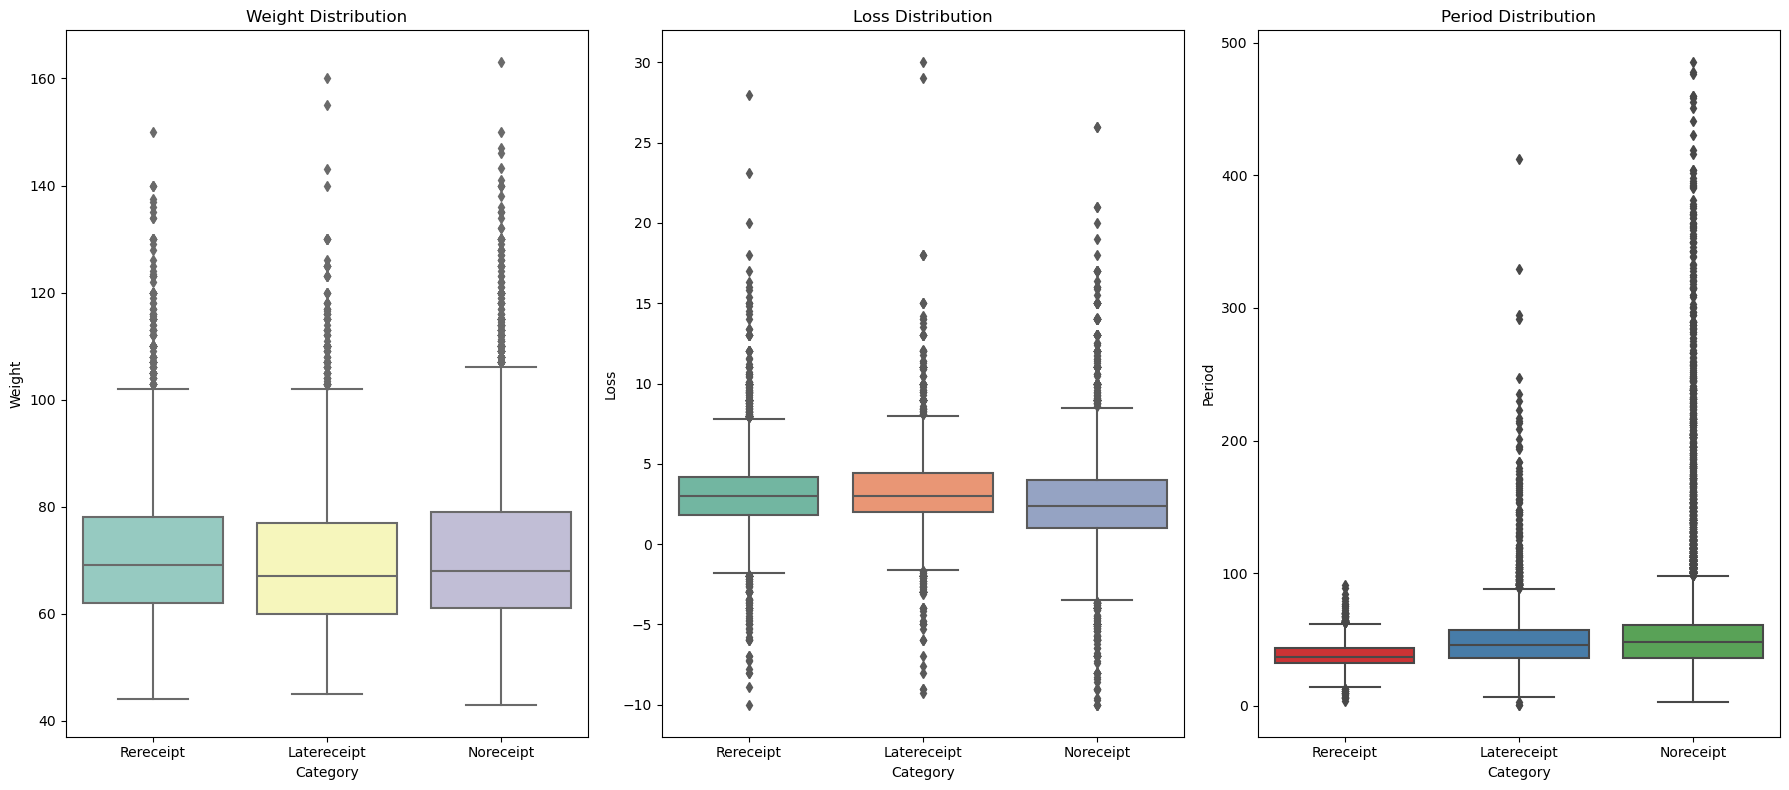

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯 시각화
plt.figure(figsize=(12, 8))

# Weight 분포 시각화
plt.subplot(1, 3, 1)
sns.boxplot(data=[rereceipt_df['Weight'], latereceipt_df['Weight'], noreceipt_df['Weight']], 
            palette='Set3')
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Weight Distribution')
plt.xlabel('Category')
plt.ylabel('Weight')

# Loss 분포 시각화
plt.subplot(1, 3, 2)
sns.boxplot(data=[rereceipt_df['Loss'], latereceipt_df['Loss'], noreceipt_df['Loss']], 
            palette='Set2')
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Loss Distribution')
plt.xlabel('Category')
plt.ylabel('Loss')

# Period 분포 시각화
plt.subplot(1, 3, 3)
sns.boxplot(data=[rereceipt_df['Period'], latereceipt_df['Period'], noreceipt_df['Period']], 
            palette='Set1')
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Period Distribution')
plt.xlabel('Category')
plt.ylabel('Period')

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod Density.png")
plt.show()


C:\Users\howsr\AppData\Local\Temp\ipykernel_28344\746299880.py:52: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\howsr\AppData\Local\Temp\ipykernel_28344\746299880.py:53: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod box.png")
C:\Users\howsr\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


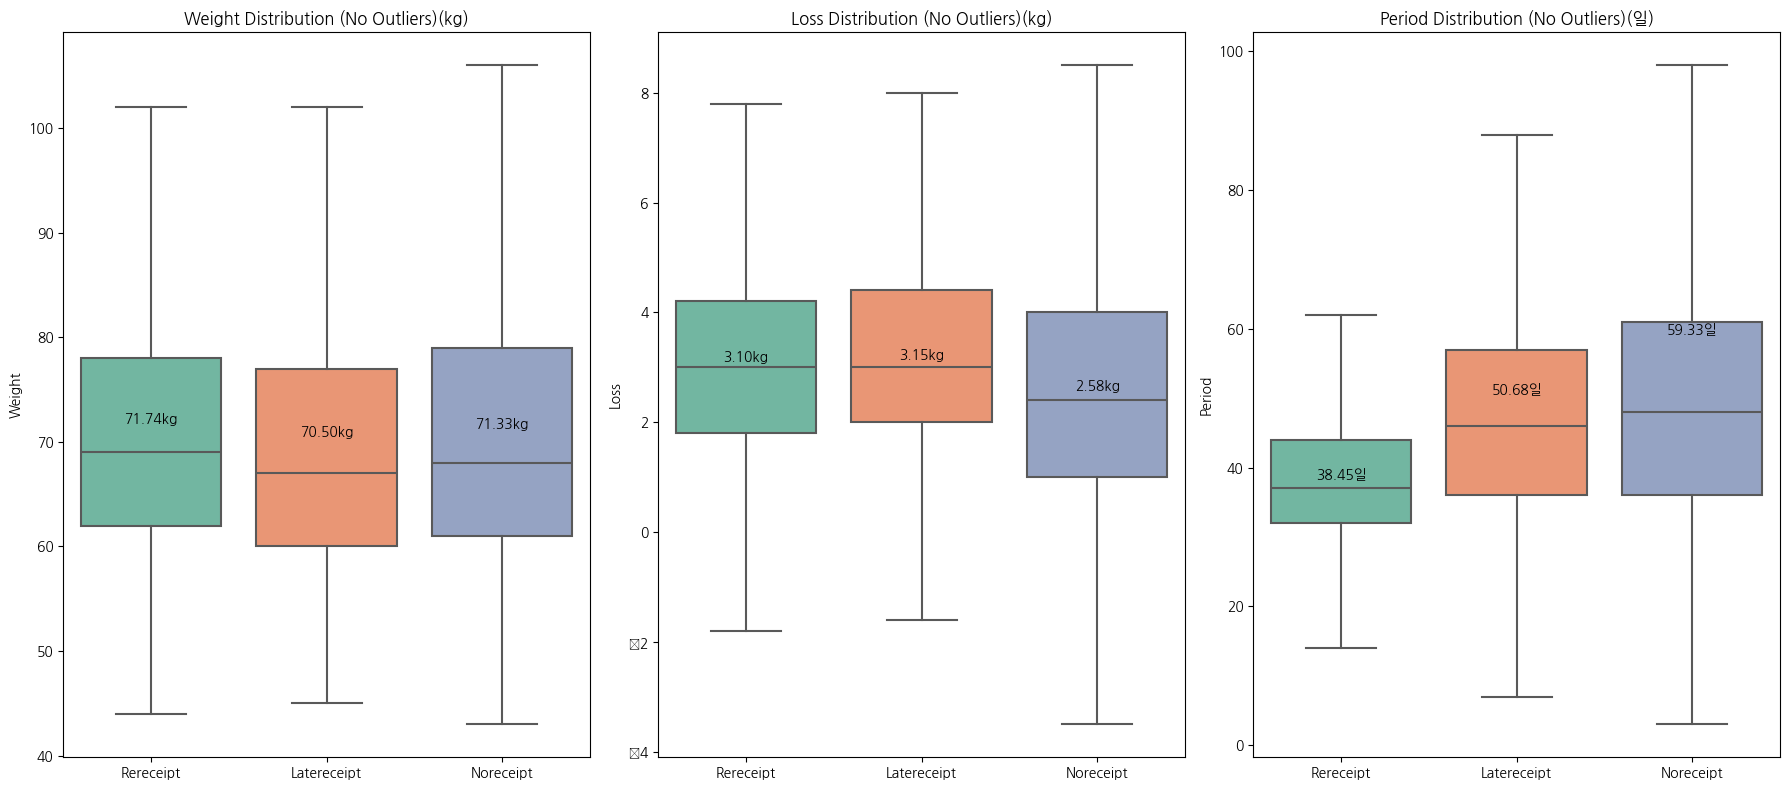

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 박스 플롯 시각화 (이상치 제외)
plt.figure(figsize=(18, 8))

# Weight 분포 시각화
plt.subplot(1, 3, 1)
sns.boxplot(data=[rereceipt_df['Weight'], latereceipt_df['Weight'], noreceipt_df['Weight']], 
            palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Weight Distribution (No Outliers)(kg)')

plt.ylabel('Weight')

# 평균값 계산 및 표시 (점은 표시하지 않고 숫자만 검정색으로 표시)
means_weight = [rereceipt_df['Weight'].mean(), latereceipt_df['Weight'].mean(), noreceipt_df['Weight'].mean()]
for i, mean in enumerate(means_weight):
    plt.text(i, mean + 0.02, f'{mean:.2f}kg', ha='center', color='black')  # 평균값 숫자 표시

# Loss 분포 시각화
plt.subplot(1, 3, 2)
sns.boxplot(data=[rereceipt_df['Loss'], latereceipt_df['Loss'], noreceipt_df['Loss']], 
            palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Loss Distribution (No Outliers)(kg)')

plt.ylabel('Loss')

# 평균값 계산 및 표시
means_loss = [rereceipt_df['Loss'].mean(), latereceipt_df['Loss'].mean(), noreceipt_df['Loss'].mean()]
for i, mean in enumerate(means_loss):
    plt.text(i, mean + 0.01, f'{mean:.2f}kg', ha='center', color='black')  # 평균값 숫자 표시

# Period 분포 시각화
plt.subplot(1, 3, 3)
sns.boxplot(data=[rereceipt_df['Period'], latereceipt_df['Period'], noreceipt_df['Period']], 
            palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Period Distribution (No Outliers)(일)')

plt.ylabel('Period')

# 평균값 계산 및 표시
means_period = [rereceipt_df['Period'].mean(), latereceipt_df['Period'].mean(), noreceipt_df['Period'].mean()]
for i, mean in enumerate(means_period):
    plt.text(i, mean + 0.01, f'{mean:.2f}일', ha='center', color='black')  # 평균값 숫자 표시



plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod box.png")
plt.show()


C:\Users\howsr\AppData\Local\Temp\ipykernel_28344\2415649281.py:74: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\howsr\AppData\Local\Temp\ipykernel_28344\2415649281.py:75: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod% box.png")
C:\Users\howsr\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


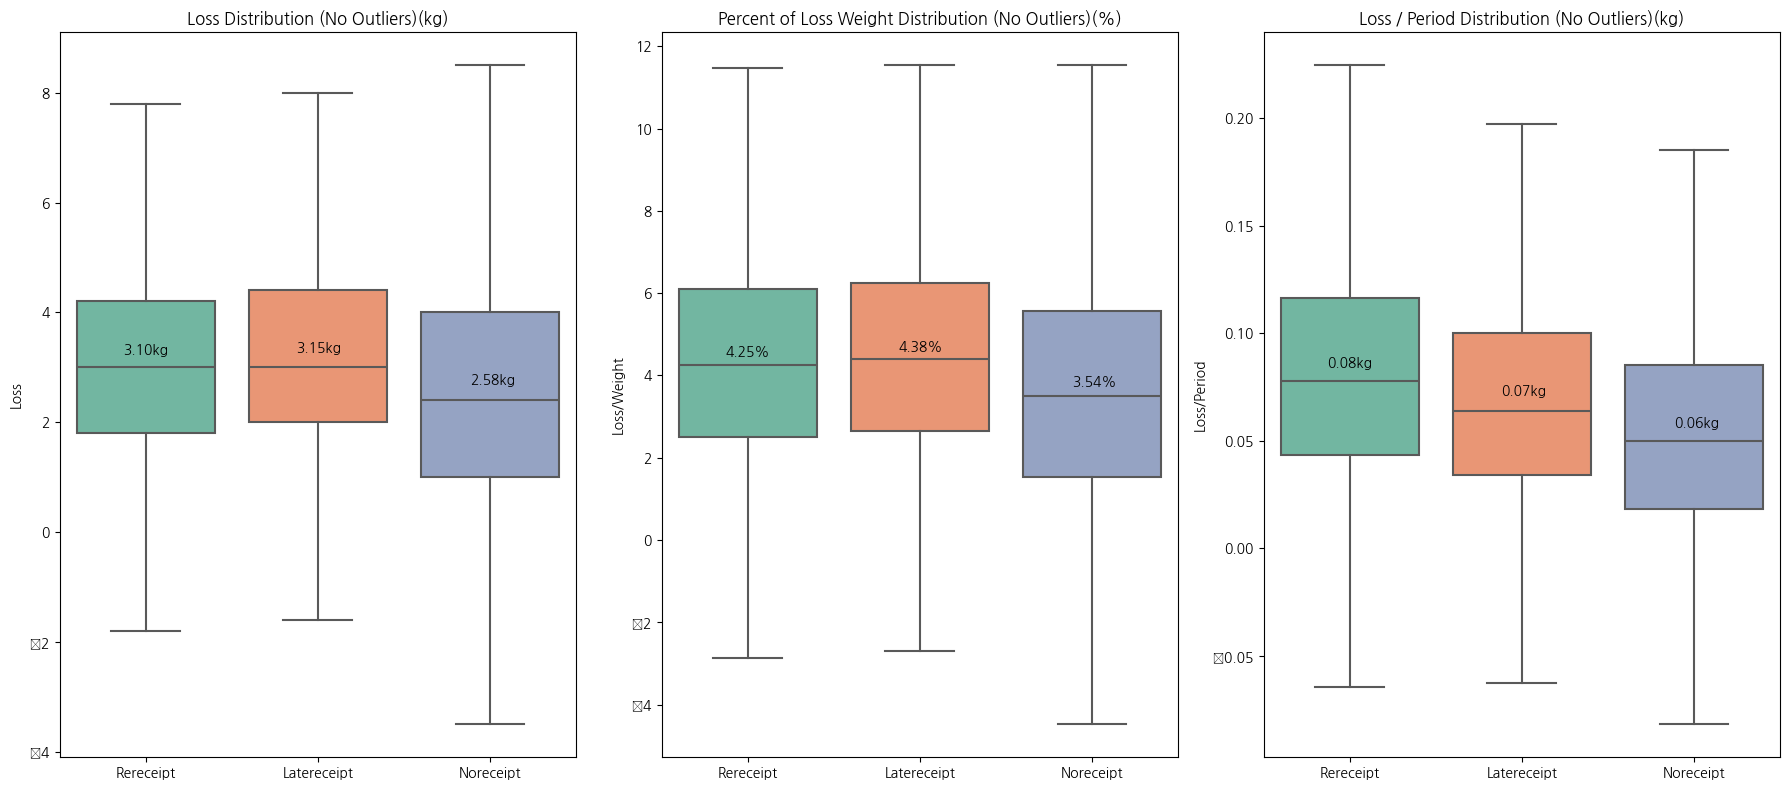

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 평균값을 표시하는 함수
def annotate_means_kg(ax, data, categories):
    for i, (category_data, label) in enumerate(zip(data, categories)):
        mean_value = category_data.mean()
        ax.annotate(f'{mean_value:.2f}kg', xy=(i, mean_value), xytext=(i, mean_value),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=10, color='black')

def annotate_means_g(ax, data, categories):
    for i, (category_data, label) in enumerate(zip(data, categories)):
        mean_value = category_data.mean()
        ax.annotate(f'{mean_value:.2f}g', xy=(i, mean_value), xytext=(i, mean_value),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=10, color='black')
        
def annotate_means_per(ax, data, categories):
    for i, (category_data, label) in enumerate(zip(data, categories)):
        mean_value = category_data.mean()
        ax.annotate(f'{mean_value:.2f}%', xy=(i, mean_value), xytext=(i, mean_value),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=10, color='black')

# 박스 플롯 시각화 (이상치 제외)
plt.figure(figsize=(18, 8))

# Loss 분포 시각화
plt.subplot(1, 3, 1)
ax1 = sns.boxplot(data=[rereceipt_df['Loss'], latereceipt_df['Loss'], noreceipt_df['Loss']], 
                      palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Loss Distribution (No Outliers)(kg)')

plt.ylabel('Loss')
# 평균값 표시
annotate_means_kg(ax1, [rereceipt_df['Loss'], latereceipt_df['Loss'], noreceipt_df['Loss']], 
                  ['Rereceipt', 'Latereceipt', 'Noreceipt'])

# Percent of Loss/Weight 분포 시각화
plt.subplot(1, 3, 2)
ax2 = sns.boxplot(data=[rereceipt_df['Loss']*100 / rereceipt_df['Weight'], 
                        latereceipt_df['Loss']*100 / latereceipt_df['Weight'], 
                        noreceipt_df['Loss']*100 / noreceipt_df['Weight']], 
                  palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Percent of Loss Weight Distribution (No Outliers)(%)')

plt.ylabel('Loss/Weight')
# 평균값 표시
annotate_means_per(ax2, [rereceipt_df['Loss']*100 / rereceipt_df['Weight'], 
                     latereceipt_df['Loss']*100 / latereceipt_df['Weight'], 
                     noreceipt_df['Loss']*100 / noreceipt_df['Weight']], 
                ['Rereceipt', 'Latereceipt', 'Noreceipt'])

# Percent of Loss/Period 분포 시각화
plt.subplot(1, 3, 3)
ax3 = sns.boxplot(data=[rereceipt_df['Loss'] / rereceipt_df['Period'], 
                        latereceipt_df['Loss']/ latereceipt_df['Period'], 
                        noreceipt_df['Loss']/ noreceipt_df['Period']], 
                  palette='Set2', showfliers=False)
plt.xticks([0, 1, 2], ['Rereceipt', 'Latereceipt', 'Noreceipt'])
plt.title('Loss / Period Distribution (No Outliers)(kg)')

plt.ylabel('Loss/Period')
# 평균값 표시
annotate_means_kg(ax3, [rereceipt_df['Loss'] / rereceipt_df['Period'],
                     latereceipt_df['Loss'] / latereceipt_df['Period'], 
                     noreceipt_df['Loss'] / noreceipt_df['Period']], 
                ['Rereceipt', 'Latereceipt', 'Noreceipt'])

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\WeightLossPeriod% box.png")
plt.show()


C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

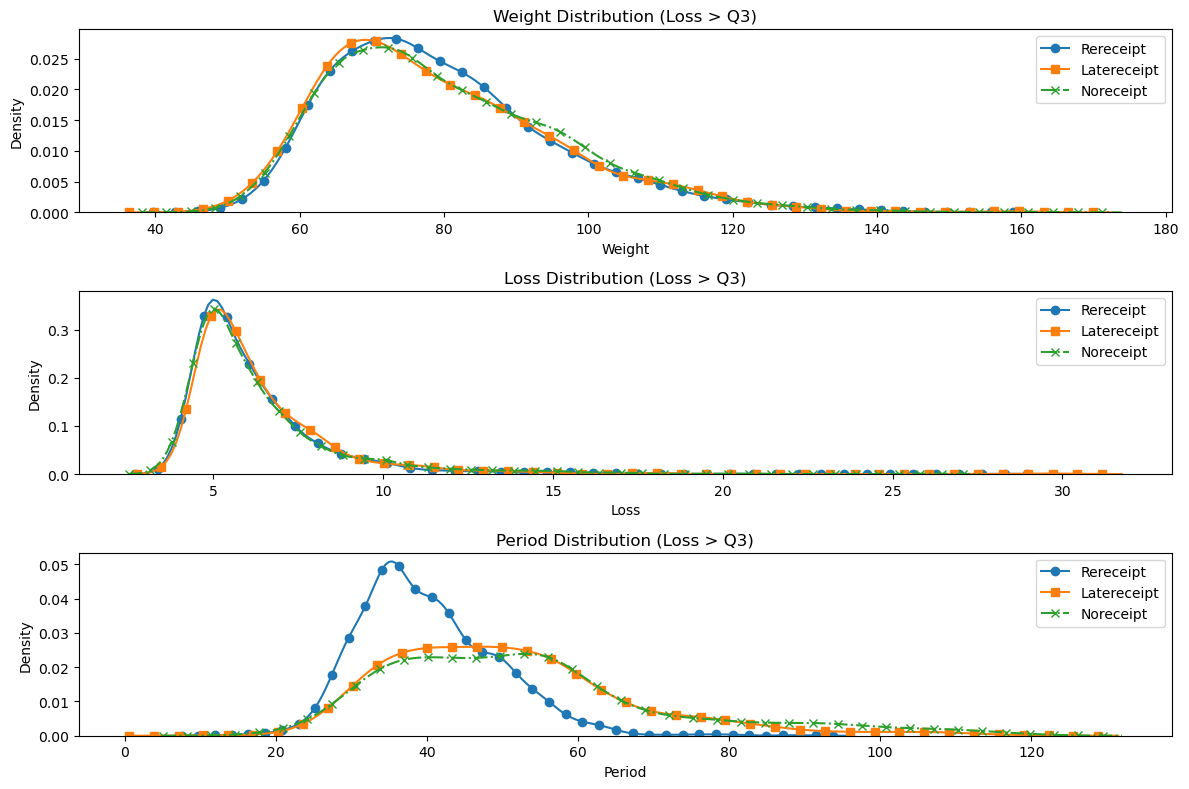

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 각 데이터프레임에서 Loss의 Q3 계산
rereceipt_q3 = rereceipt_df['Loss'].quantile(0.75)
latereceipt_q3 = latereceipt_df['Loss'].quantile(0.75)
noreceipt_q3 = noreceipt_df['Loss'].quantile(0.75)

# Q3보다 큰 값들만 필터링
rereceipt_filtered_q3 = rereceipt_df[rereceipt_df['Loss'] > rereceipt_q3]
latereceipt_filtered_q3 = latereceipt_df[latereceipt_df['Loss'] > latereceipt_q3]
noreceipt_filtered_q3 = noreceipt_df[noreceipt_df['Loss'] > noreceipt_q3]

# KDE 시각화
plt.figure(figsize=(12, 8))
markevery = 5

# Weight 분포 시각화
plt.subplot(3, 1, 1)
sns.kdeplot(rereceipt_filtered_q3['Weight'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q3['Weight'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q3['Weight'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Weight Distribution (Loss > Q3)')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.legend()

# Loss 분포 시각화
plt.subplot(3, 1, 2)
sns.kdeplot(rereceipt_filtered_q3['Loss'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q3['Loss'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q3['Loss'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Loss Distribution (Loss > Q3)')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()

# Period 분포 시각화
plt.subplot(3, 1, 3)
sns.kdeplot(rereceipt_filtered_q3['Period'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q3[latereceipt_filtered_q3['Period'] < 120]['Period'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q3[noreceipt_filtered_q3['Period'] < 120]['Period'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Period Distribution (Loss > Q3)')
plt.xlabel('Period')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\상위 25 WeightLossPeriod dens.png")
plt.show()


C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

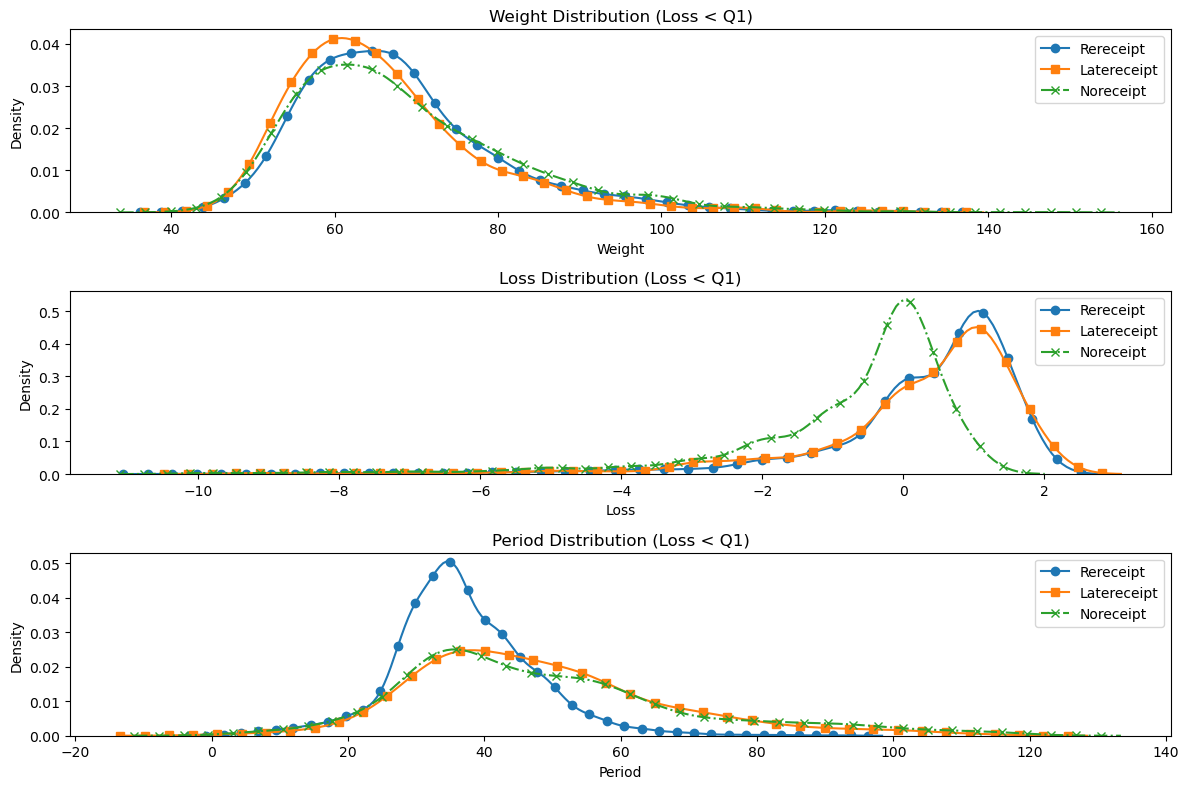

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 각 데이터프레임에서 Loss의 Q1 계산
rereceipt_q1 = rereceipt_df['Loss'].quantile(0.25)
latereceipt_q1 = latereceipt_df['Loss'].quantile(0.25)
noreceipt_q1 = noreceipt_df['Loss'].quantile(0.25)

# Q1보다 작은 값들만 필터링
rereceipt_filtered_q1 = rereceipt_df[rereceipt_df['Loss'] < rereceipt_q1]
latereceipt_filtered_q1 = latereceipt_df[latereceipt_df['Loss'] < latereceipt_q1]
noreceipt_filtered_q1 = noreceipt_df[noreceipt_df['Loss'] < noreceipt_q1]

# KDE 시각화
plt.figure(figsize=(12, 8))
markevery = 5

# Weight 분포 시각화
plt.subplot(3, 1, 1)
sns.kdeplot(rereceipt_filtered_q1['Weight'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q1['Weight'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q1['Weight'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Weight Distribution (Loss < Q1)')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.legend()

# Loss 분포 시각화
plt.subplot(3, 1, 2)
sns.kdeplot(rereceipt_filtered_q1['Loss'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q1['Loss'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q1['Loss'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Loss Distribution (Loss < Q1)')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()

# Period 분포 시각화
plt.subplot(3, 1, 3)
sns.kdeplot(rereceipt_filtered_q1['Period'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_filtered_q1[latereceipt_filtered_q1['Period'] < 120]['Period'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_filtered_q1[noreceipt_filtered_q1['Period'] < 120]['Period'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)
plt.title('Period Distribution (Loss < Q1)')
plt.xlabel('Period')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\하위 25 WeightLossPeriod dens.png")
plt.show()


In [35]:
# rereceipt_df = pd.DataFrame.from_dict(rereceipt_dict, orient='index')
# latereceipt_df = pd.DataFrame.from_dict(latereceipt_dict, orient='index')
# noreceipt_df = pd.DataFrame.from_dict(noreceipt_dict, orient='index')
rereceipt_info_df = info_df[info_df.index.isin(rereceipt_df.index)]
latereceipt_info_df = info_df[info_df.index.isin(latereceipt_df.index)]
noreceipt_info_df = info_df[info_df.index.isin(noreceipt_df.index)]

In [36]:
noreceipt_info_df = noreceipt_info_df[noreceipt_info_df['PatientSex'] != 0]

In [40]:
noreceipt_info_df[noreceipt_info_df['PatientFirstDate'] > '2023-11-01']

,Region,PatientID,PatientChartNo,PatientName,PatientAddr11,PatientFirstDate,Age,PatientSex,Description,ProgressNote,...,Alcohol_거의 마시지 않는다 (월 1-2회),Alcohol_기타,Alcohol_주 1회,Alcohol_주 2회 이상,HanbangX,HanbangYX,HanbangYY,YangbangX,YangbangYX,YangbangYY
31,bundang,92536,123151.00,김미림,"경기도 수원시 팔달구 월드컵로321번길 17 (우만동, 신미주아파트)",2023-11-29,35.00,2,NaN,#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:156 / 65 / 경도비만(...,...,0,0,0,1,0,1,0,1,0,0
78,bundang,238634,123024.00,조효선,"경기도 성남시 분당구 정자로 115 (정자동, 한솔마을주공아파트)",2023-11-20,42.00,2,내원경로 임지연(강68533/핸7253),#비만(내원초진)\n\n\n여자\n\nㆍ 키/체중/BMI:154 / 53 / 정상(...,...,0,0,1,0,1,0,0,1,0,0
112,bundang,298997,123134.00,조아름,전라남도 순천시 역전길 67 (조곡동),2023-11-29,35.00,2,내원경로 조아라(홍69010/핸9002),\n#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:158 / 59 / 과체중...,...,0,0,1,0,1,0,0,1,0,0
119,bundang,320521,123129.00,고은정,"경기도 수원시 팔달구 고등로 15 (고등동, 수원역푸르지오자이)",2023-11-28,52.00,2,NaN,#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:160 / 68 / 경도비만(...,...,1,0,0,0,1,0,0,0,1,0
663,bundang,436510,122921.00,최윤희,경기도 용인시 수지구 풍덕천로189번길 4-10 (풍덕천동),2023-11-11,19.00,2,내원경로 김보미(잠53490/핸3004),\n#비만(내원초진)\n\n\n여자\n\nㆍ 키/체중/BMI:162 / 75 / 경...,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43913,incheon,15205,2854.00,박재현,"인천광역시 연수구 능허대로 343 (동춘동, 송도 파크레인 동일하이빌)",2024-01-29,31.00,1,NaN,#비만(내원초진)\n\n남자\n\nㆍ 키/체중/BMI:168 / 93 / 중도 비만...,...,0,0,1,0,0,1,0,1,0,0
43914,incheon,15206,2859.00,김영순,"인천광역시 연수구 신송로118번길 6 (송도동, 송도풍림아이원1단지아파트)",2024-01-30,54.00,2,부천34060,#비만(내원재진) - 지점이동\n\n* 최고혈압/최저혈압/맥박: (150 / 79/...,...,0,0,0,1,1,0,0,1,0,0
43918,incheon,15231,2875.00,박주현,"인천광역시 계양구 오조산로62번길 10 (계산동, 은행마을 태산아파트)",2024-01-29,40.00,2,NaN,#비만(내원초진)\n\n여자\n\nㆍ 키/체중/BMI:160 / 73 / 경도비만(...,...,0,0,0,1,0,0,1,1,0,0
43919,incheon,15235,2852.00,민세환,"서울특별시 구로구 고척로52길 48 (고척동, 고척대우아파트)",2024-01-29,35.00,1,비대면,#비만(비대면초진)\n\n남자\n\nㆍ 키/체중/BMI:172 / 82 / 경도비만...,...,1,0,0,0,1,0,0,1,0,0


C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


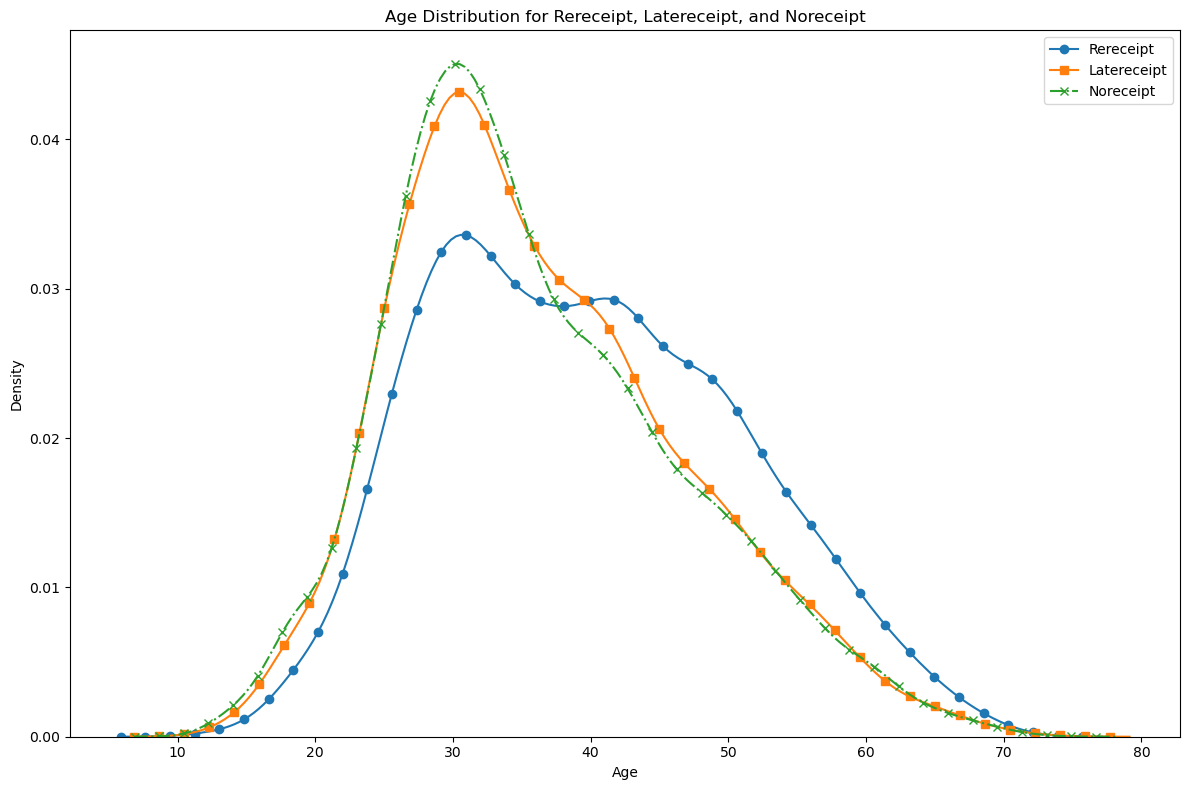

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 관련 변수
markevery = 5  # 마커를 표시할 간격

# KDE 시각화
plt.figure(figsize=(12, 8))

# 'Age'의 밀도 분포 시각화
sns.kdeplot(rereceipt_info_df['Age'], label='Rereceipt', linestyle='-', marker='o', markevery=markevery)
sns.kdeplot(latereceipt_info_df['Age'], label='Latereceipt', linestyle='-', marker='s', markevery=markevery)
sns.kdeplot(noreceipt_info_df['Age'], label='Noreceipt', linestyle='-.', marker='x', markevery=markevery)

# 그래프 제목 및 축 레이블 설정
plt.title('Age Distribution for Rereceipt, Latereceipt, and Noreceipt')
plt.xlabel('Age')
plt.ylabel('Density')

# 범례 표시
plt.legend()

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Age.png")
# 그래프 표시
plt.show()


In [35]:
# 폰트 이름으로 설정
plt.rc('font', family='NanumGothic')

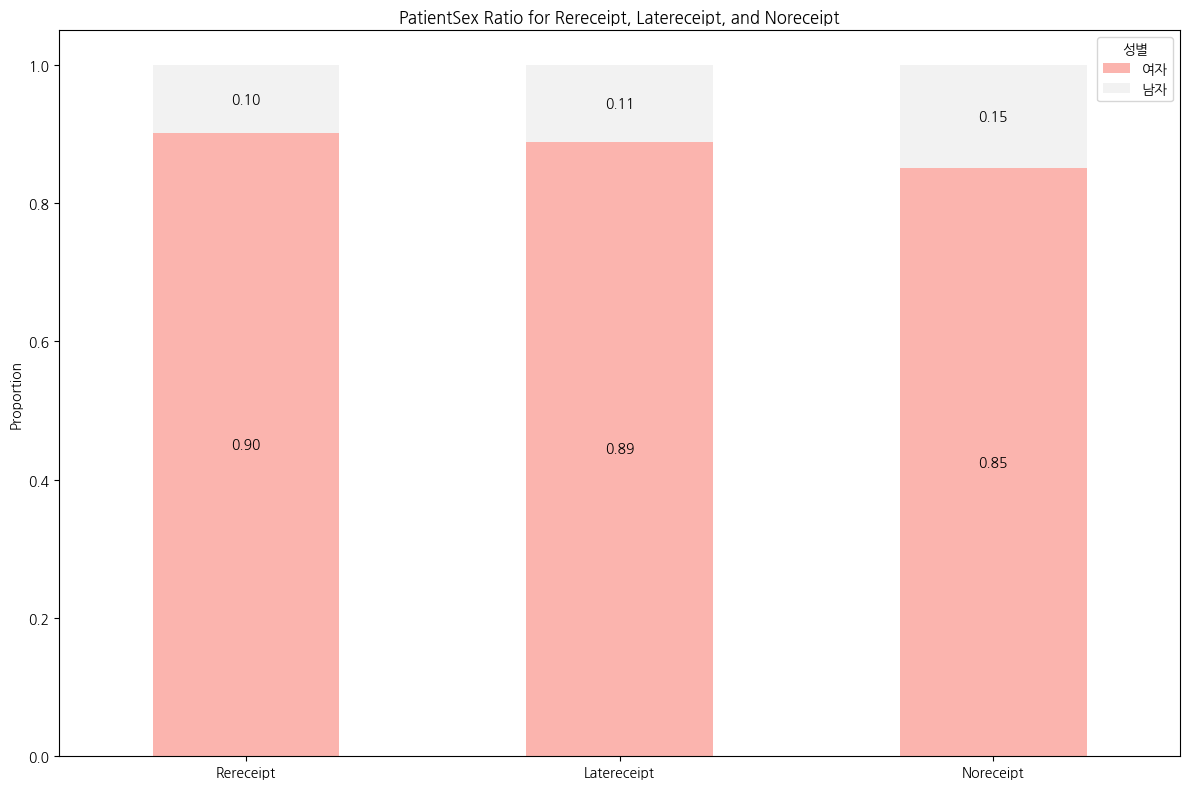

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임에서 'PatientSex'의 비율 계산
rereceipt_sex_ratio = rereceipt_info_df['PatientSex'].value_counts(normalize=True)
latereceipt_sex_ratio = latereceipt_info_df['PatientSex'].value_counts(normalize=True)
noreceipt_sex_ratio = noreceipt_info_df['PatientSex'].value_counts(normalize=True)

# 비율을 데이터프레임으로 정리
sex_ratio_df = pd.DataFrame({
    'Rereceipt': rereceipt_sex_ratio,
    'Latereceipt': latereceipt_sex_ratio,
    'Noreceipt': noreceipt_sex_ratio
}).T

# 비율을 채우기 (비율이 0인 경우에도 그래프에 표시되도록)
sex_ratio_df = sex_ratio_df.fillna(0)

# 막대 그래프 시각화
plt.figure(figsize=(12,8))
ax = sex_ratio_df.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('PatientSex Ratio for Rereceipt, Latereceipt, and Noreceipt')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(labels=['여자', '남자'], title='성별', loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Sex.png")
# 그래프 표시
plt.show()


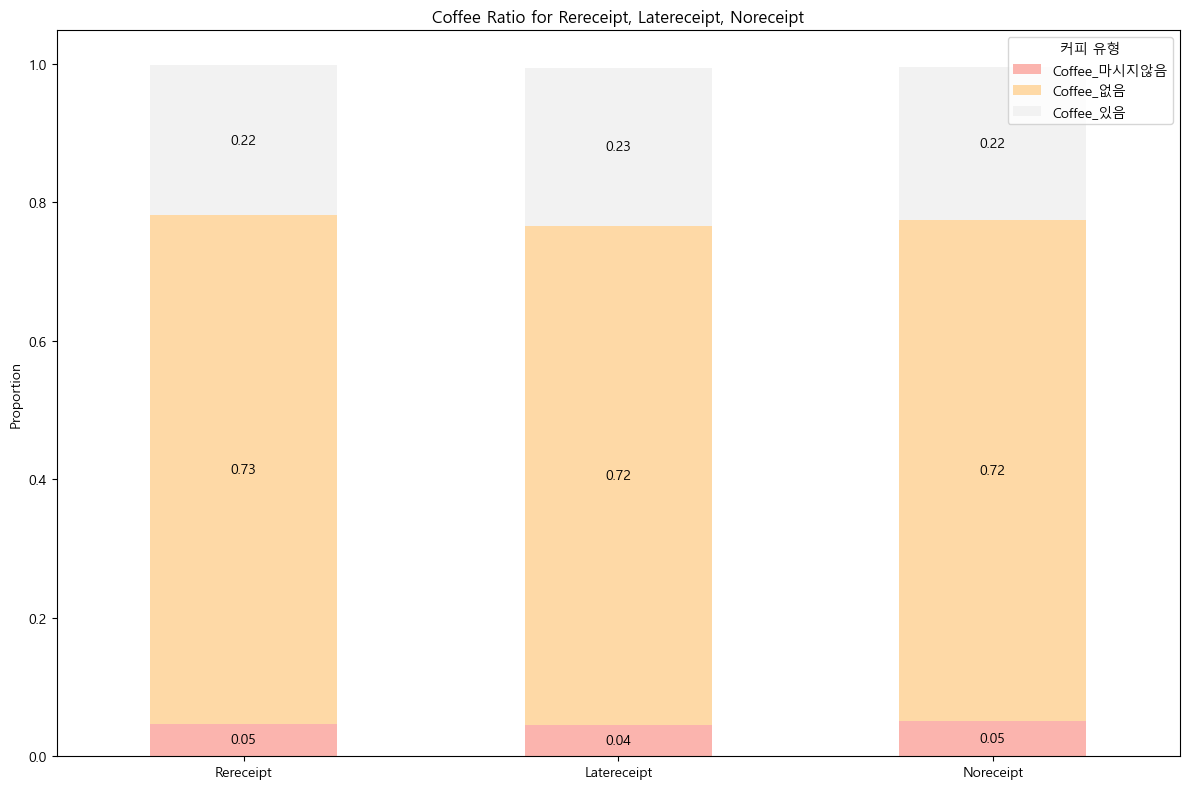

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (예: 맑은 고딕, 한컴 바탕 등)
# 이 부분은 시스템에 따라 적절한 폰트명으로 수정해야 할 수 있습니다.
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # macOS
# matplotlib.rcParams['font.family'] = 'NanumGothic'  # Linux

# 네 가지 컬럼의 비율 계산
coffee_columns = [ 'Coffee_마시지않음', 'Coffee_없음', 'Coffee_있음']

# 각 컬럼의 비율을 계산
coffee_ratios = pd.DataFrame({
    'Rereceipt': rereceipt_info_df[coffee_columns].mean(),
    'Latereceipt': latereceipt_info_df[coffee_columns].mean(),
    'Noreceipt': noreceipt_info_df[coffee_columns].mean()
}).T

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = coffee_ratios.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('Coffee Ratio for Rereceipt, Latereceipt, Noreceipt')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='커피 유형', loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\coffee.png")
# 그래프 표시
plt.show()

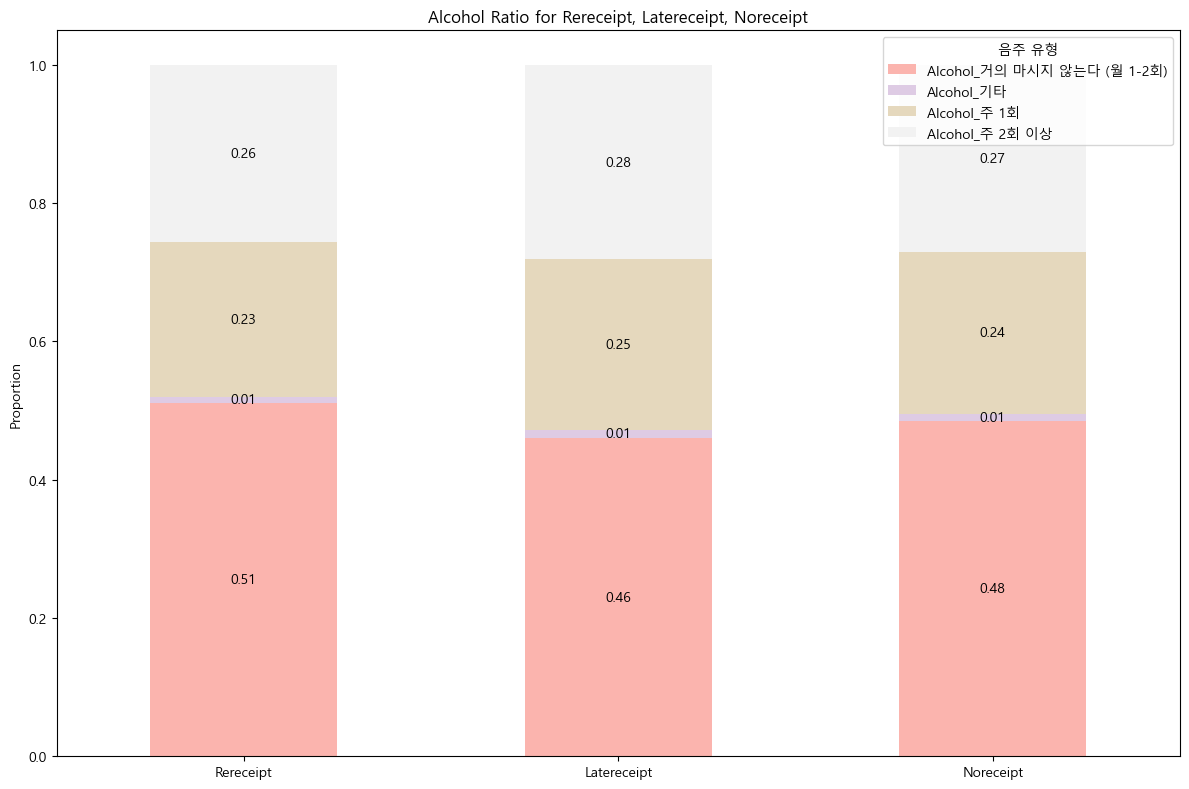

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (예: 맑은 고딕, 한컴 바탕 등)
# 이 부분은 시스템에 따라 적절한 폰트명으로 수정해야 할 수 있습니다.
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # macOS
# matplotlib.rcParams['font.family'] = 'NanumGothic'  # Linux

# 네 가지 컬럼의 비율 계산
columns = [ 'Alcohol_거의 마시지 않는다 (월 1-2회)',
 'Alcohol_기타',
 'Alcohol_주 1회',
 'Alcohol_주 2회 이상']

# 각 컬럼의 비율을 계산
coffee_ratios = pd.DataFrame({
    'Rereceipt': rereceipt_info_df[columns].mean(),
    'Latereceipt': latereceipt_info_df[columns].mean(),
    'Noreceipt': noreceipt_info_df[columns].mean()
}).T

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = coffee_ratios.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('Alcohol Ratio for Rereceipt, Latereceipt, Noreceipt')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='음주 유형', loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Alcohol.png")
# 그래프 표시
plt.show()


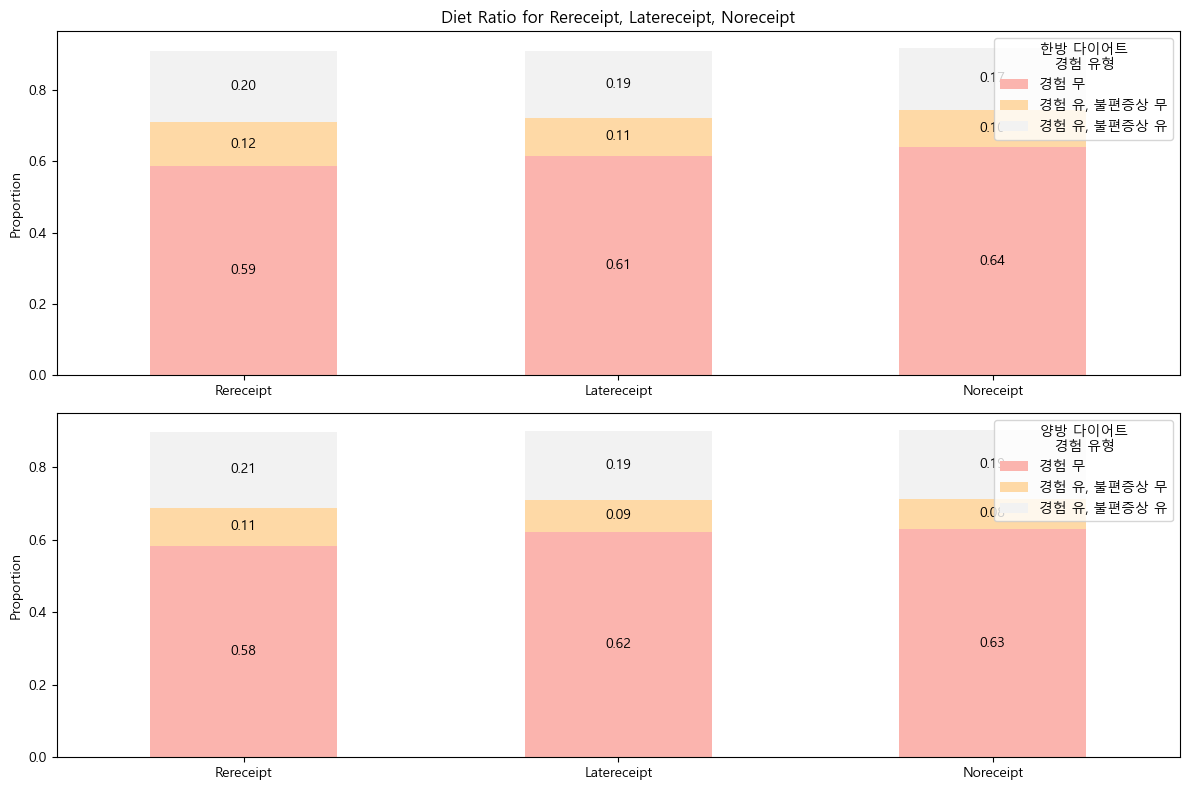

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (예: 맑은 고딕, 한컴 바탕 등)
# 이 부분은 시스템에 따라 적절한 폰트명으로 수정해야 할 수 있습니다.
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # macOS
# matplotlib.rcParams['font.family'] = 'NanumGothic'  # Linux

# 네 가지 컬럼의 비율 계산
columns = [ 'HanbangX',
 'HanbangYX',
 'HanbangYY']

# 각 컬럼의 비율을 계산
coffee_ratios = pd.DataFrame({
    'Rereceipt': rereceipt_info_df[columns].mean(),
    'Latereceipt': latereceipt_info_df[columns].mean(),
    'Noreceipt': noreceipt_info_df[columns].mean()
}).T


# 네 가지 컬럼의 비율 계산
columns = [  'YangbangX',
 'YangbangYX',
 'YangbangYY']

# 각 컬럼의 비율을 계산
Y_ratios = pd.DataFrame({
    'Rereceipt': rereceipt_info_df[columns].mean(),
    'Latereceipt': latereceipt_info_df[columns].mean(),
    'Noreceipt': noreceipt_info_df[columns].mean()
}).T


# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

ax = coffee_ratios.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('Diet Ratio for Rereceipt, Latereceipt, Noreceipt')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='한방 다이어트\n   경험 유형',labels=['경험 무', '경험 유, 불편증상 무', '경험 유, 불편증상 유'], loc='upper right')

plt.subplot(2, 1, 2)

ax = Y_ratios.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='양방 다이어트\n   경험 유형',labels=['경험 무', '경험 유, 불편증상 무', '경험 유, 불편증상 유'], loc='upper right')
# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Diet.png")

# 그래프 표시
plt.show()


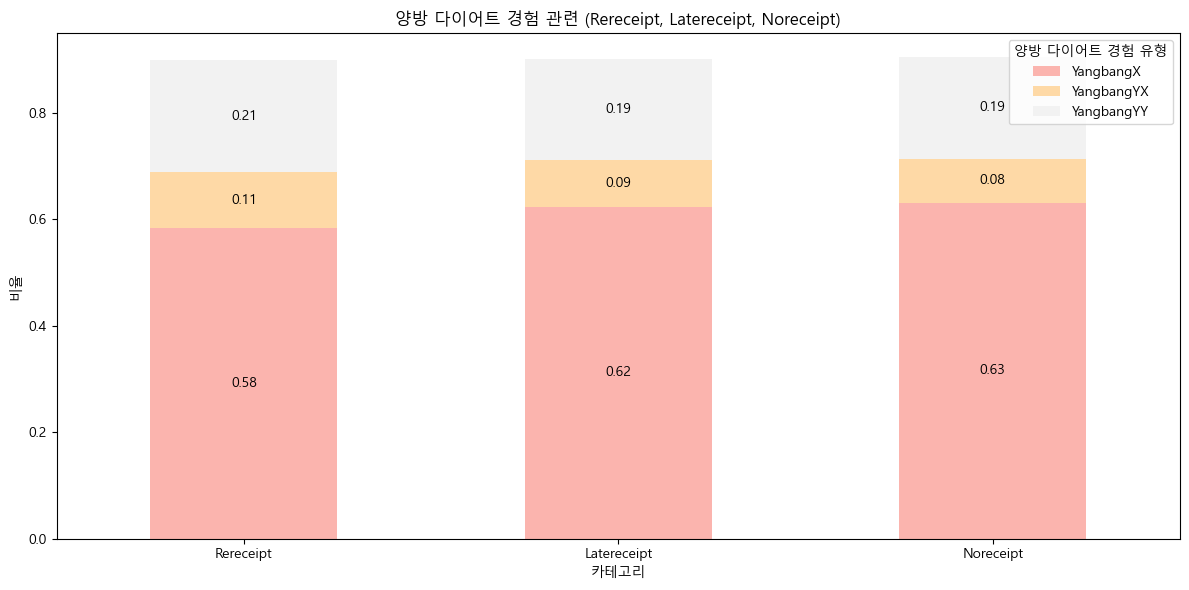

In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (예: 맑은 고딕, 한컴 바탕 등)
# 이 부분은 시스템에 따라 적절한 폰트명으로 수정해야 할 수 있습니다.
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic'  # macOS
# matplotlib.rcParams['font.family'] = 'NanumGothic'  # Linux

# 네 가지 컬럼의 비율 계산
columns = [  'YangbangX',
 'YangbangYX',
 'YangbangYY']

# 각 컬럼의 비율을 계산
coffee_ratios = pd.DataFrame({
    'Rereceipt': rereceipt_info_df[columns].mean(),
    'Latereceipt': latereceipt_info_df[columns].mean(),
    'Noreceipt': noreceipt_info_df[columns].mean()
}).T

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
ax = coffee_ratios.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('양방 다이어트 경험 관련 (Rereceipt, Latereceipt, Noreceipt)')
plt.xlabel('카테고리')
plt.ylabel('비율')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='양방 다이어트 경험 유형', loc='upper right')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()


In [452]:
rereceipt_info_df['Month'].value_counts()

Month
5     521
6     505
8     490
3     485
2     469
7     466
4     466
12    413
11    408
1     408
10    112
9      95
Name: count, dtype: int64

C:\Users\howsr\AppData\Local\Temp\ipykernel_10084\1692414447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_10084\1692414447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_10084\1692414447.py:10: SettingWithCopyWarning: 
A

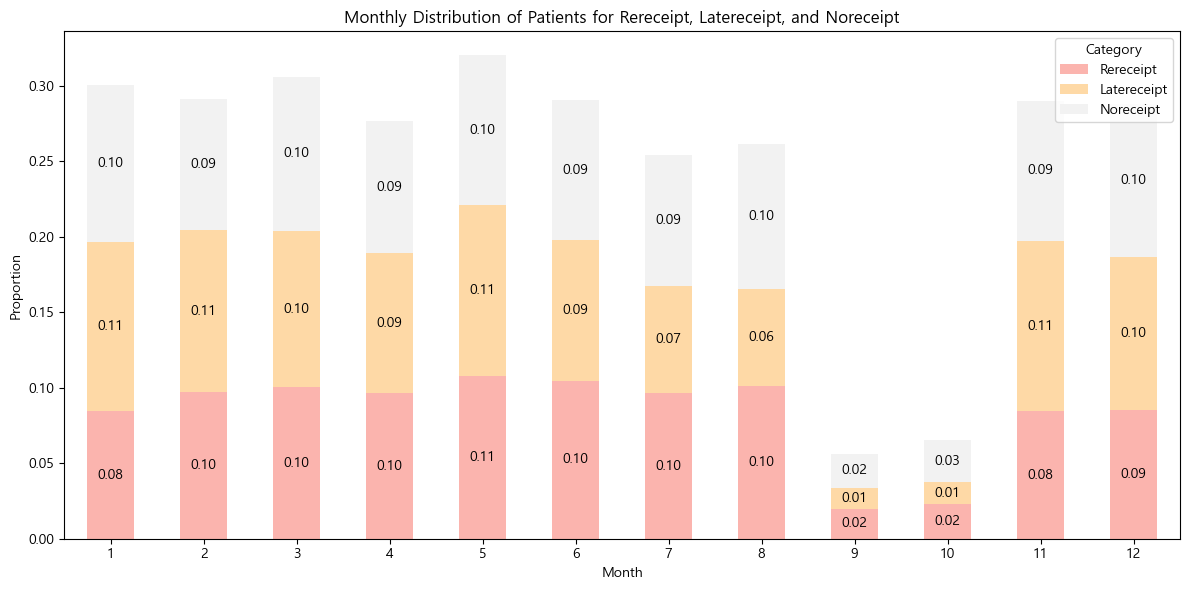

In [451]:
import pandas as pd
import matplotlib.pyplot as plt

# 각 데이터프레임에서 PatientFirstDate 열을 datetime 형식으로 변환
rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
noreceipt_info_df['PatientFirstDate'] = pd.to_datetime(noreceipt_info_df['PatientFirstDate'])

# 월별 데이터 추출
rereceipt_info_df['Month'] = rereceipt_info_df['PatientFirstDate'].dt.month
latereceipt_info_df['Month'] = latereceipt_info_df['PatientFirstDate'].dt.month
noreceipt_info_df['Month'] = noreceipt_info_df['PatientFirstDate'].dt.month

# 월별 비율 계산
rereceipt_monthly_ratio = rereceipt_info_df['Month'].value_counts(normalize=True).sort_index()
latereceipt_monthly_ratio = latereceipt_info_df['Month'].value_counts(normalize=True).sort_index()
noreceipt_monthly_ratio = noreceipt_info_df['Month'].value_counts(normalize=True).sort_index()

# 비율을 데이터프레임으로 정리
monthly_ratio_df = pd.DataFrame({
    'Rereceipt': rereceipt_monthly_ratio,
    'Latereceipt': latereceipt_monthly_ratio,
    'Noreceipt': noreceipt_monthly_ratio
}).fillna(0)  # NaN 값을 0으로 채우기

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
ax = monthly_ratio_df.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('Monthly Distribution of Patients for Rereceipt, Latereceipt, and Noreceipt')
plt.xlabel('Month')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='Category', loc='upper right')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()


C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\2323084433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\2323084433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\2323084433.py:10: SettingWithCopyWarning: 
A

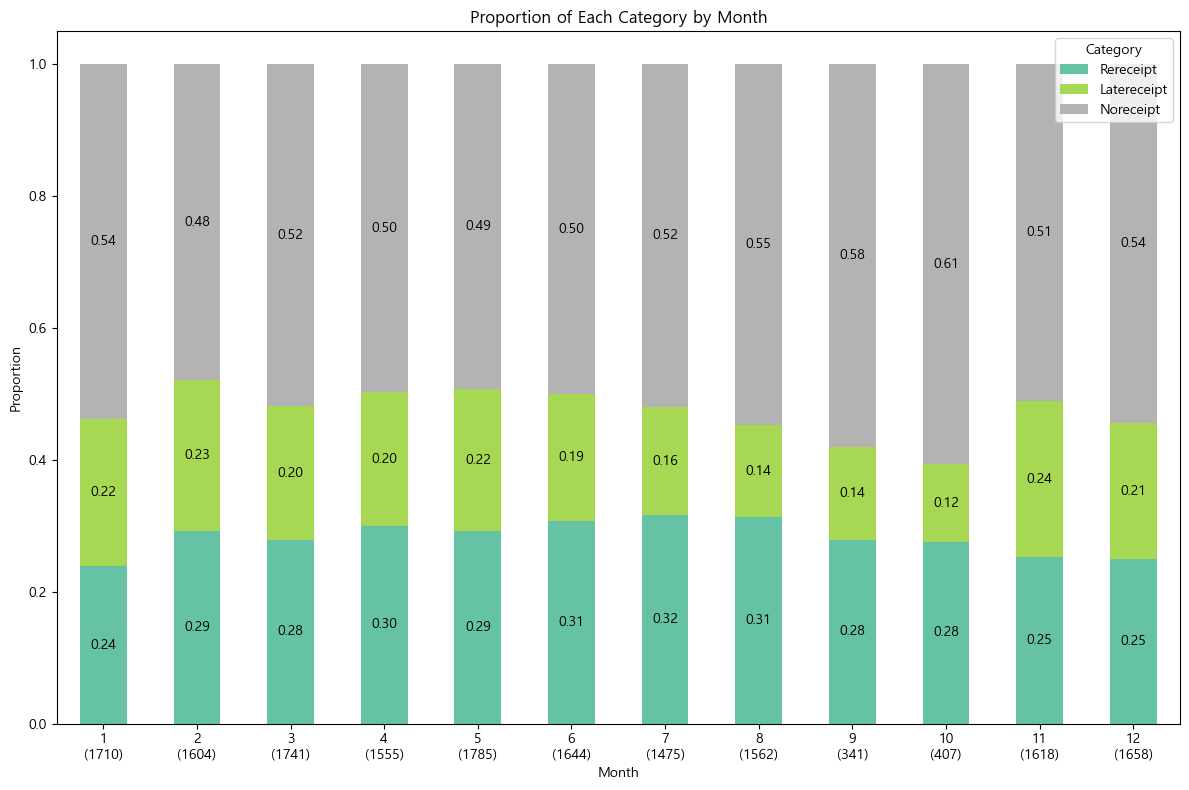

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# 각 데이터프레임에서 PatientFirstDate 열을 datetime 형식으로 변환
rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
noreceipt_info_df['PatientFirstDate'] = pd.to_datetime(noreceipt_info_df['PatientFirstDate'])

# 월별 데이터 추출
rereceipt_info_df['Month'] = rereceipt_info_df['PatientFirstDate'].dt.month
latereceipt_info_df['Month'] = latereceipt_info_df['PatientFirstDate'].dt.month
noreceipt_info_df['Month'] = noreceipt_info_df['PatientFirstDate'].dt.month

# 각 달별로 각 데이터군의 개수 계산
monthly_counts = pd.DataFrame({
    'Rereceipt': rereceipt_info_df['Month'].value_counts().sort_index(),
    'Latereceipt': latereceipt_info_df['Month'].value_counts().sort_index(),
    'Noreceipt': noreceipt_info_df['Month'].value_counts().sort_index()
}).fillna(0)  # NaN 값을 0으로 채우기

# 각 달별 비율 계산
monthly_ratios = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = monthly_ratios.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

# x축 레이블 수정: 월과 총 데이터 개수(N) 추가
x_labels = [f'{month}\n({int(monthly_counts.loc[month].sum())})' for month in monthly_counts.index]
ax.set_xticklabels(x_labels)

# 그래프 제목 및 축 레이블 설정
plt.title('Proportion of Each Category by Month')
plt.xlabel('Month')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='Category', loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Month.png")
# 그래프 표시
plt.show()


C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1405112338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1405112338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1405112338.py:10: SettingWithCopyWarning: 
A

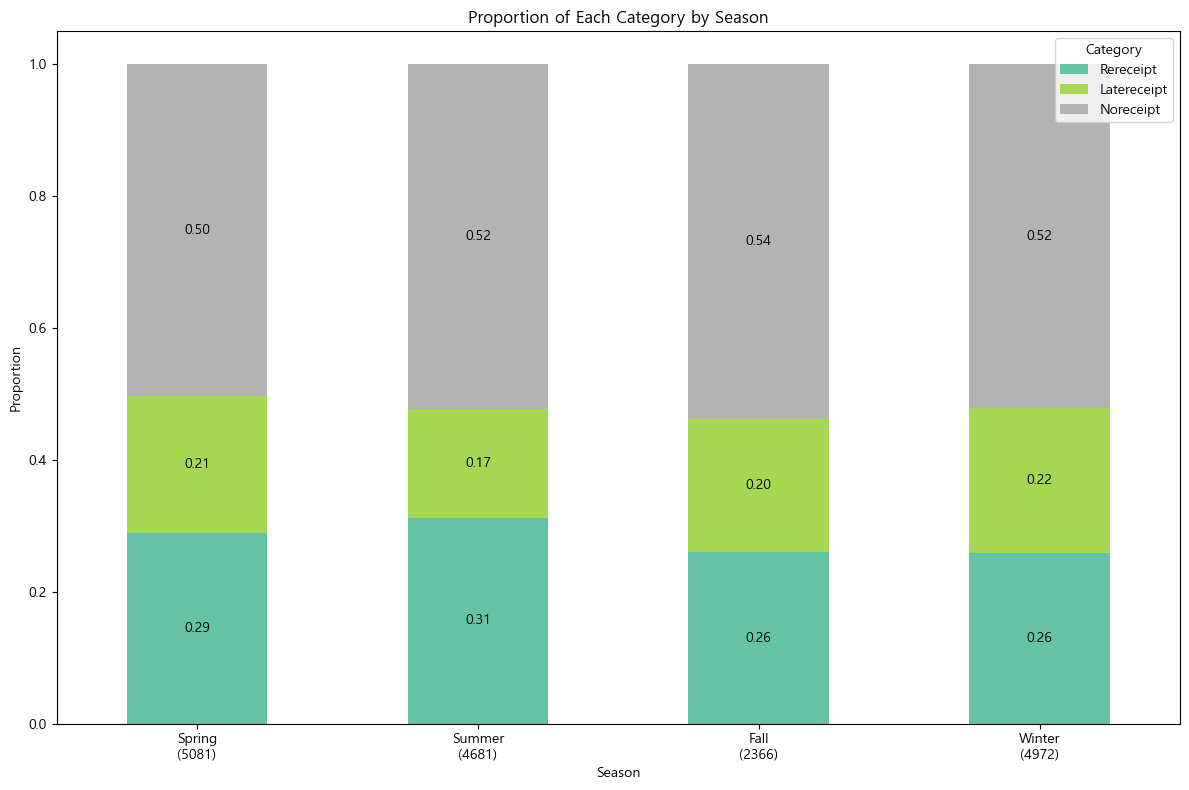

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# 각 데이터프레임에서 PatientFirstDate 열을 datetime 형식으로 변환
rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
noreceipt_info_df['PatientFirstDate'] = pd.to_datetime(noreceipt_info_df['PatientFirstDate'])

# 월별 데이터 추출
rereceipt_info_df['Month'] = rereceipt_info_df['PatientFirstDate'].dt.month
latereceipt_info_df['Month'] = latereceipt_info_df['PatientFirstDate'].dt.month
noreceipt_info_df['Month'] = noreceipt_info_df['PatientFirstDate'].dt.month

# 월을 계절로 변환하는 함수
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# 각 데이터프레임에 계절 정보 추가
rereceipt_info_df['Season'] = rereceipt_info_df['Month'].apply(month_to_season)
latereceipt_info_df['Season'] = latereceipt_info_df['Month'].apply(month_to_season)
noreceipt_info_df['Season'] = noreceipt_info_df['Month'].apply(month_to_season)

# 계절 순서 정의 (봄, 여름, 가을, 겨울)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# 각 계절별로 각 데이터군의 개수 계산
seasonal_counts = pd.DataFrame({
    'Rereceipt': rereceipt_info_df['Season'].value_counts().reindex(season_order).fillna(0),
    'Latereceipt': latereceipt_info_df['Season'].value_counts().reindex(season_order).fillna(0),
    'Noreceipt': noreceipt_info_df['Season'].value_counts().reindex(season_order).fillna(0)
})

# 각 계절별 비율 계산
seasonal_ratios = seasonal_counts.div(seasonal_counts.sum(axis=1), axis=0)

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = seasonal_ratios.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

# x축 레이블 수정: 계절 이름 밑에 데이터 개수 추가
ax.set_xticklabels([f'{season}\n({int(seasonal_counts.sum(axis = 1)[season])})' for season in season_order])

# 그래프 제목 및 축 레이블 설정
plt.title('Proportion of Each Category by Season')
plt.xlabel('Season')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='Category', loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Season.png")
# 그래프 표시
plt.show()


C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1988181828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1988181828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
C:\Users\howsr\AppData\Local\Temp\ipykernel_58308\1988181828.py:10: SettingWithCopyWarning: 
A

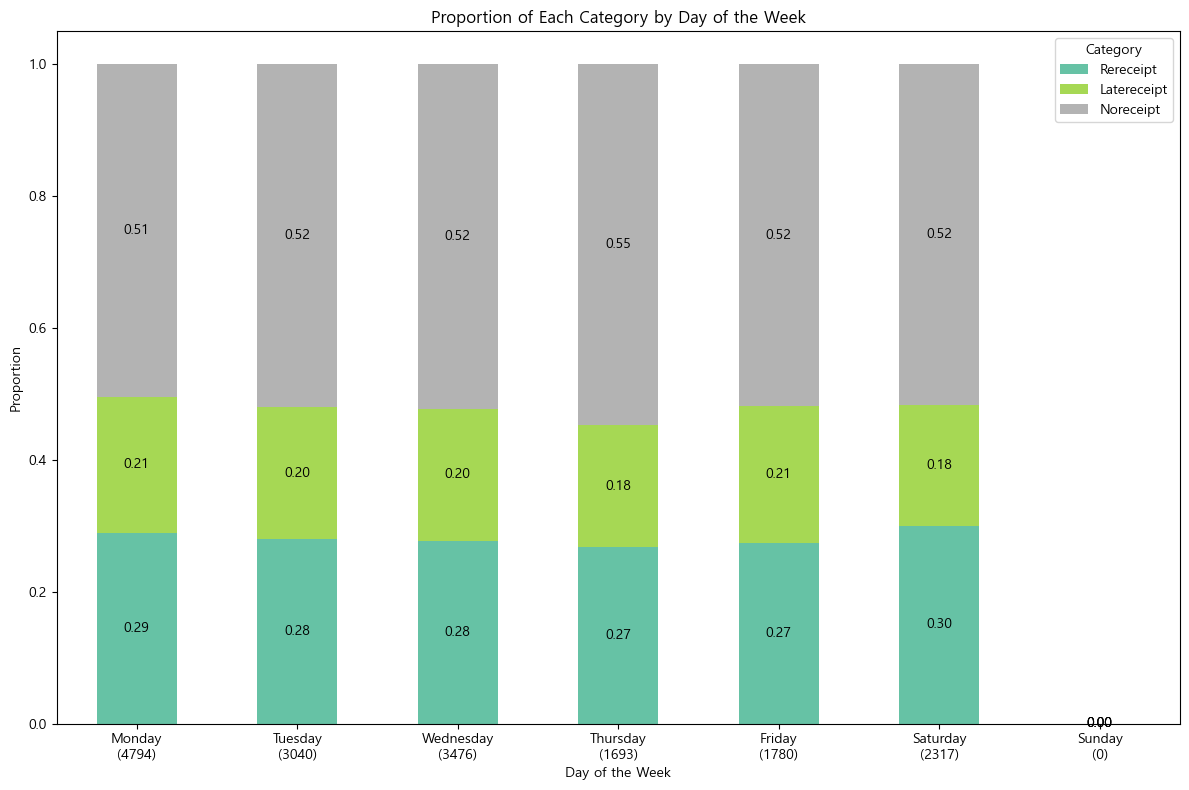

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# 각 데이터프레임에서 PatientFirstDate 열을 datetime 형식으로 변환
rereceipt_info_df['PatientFirstDate'] = pd.to_datetime(rereceipt_info_df['PatientFirstDate'])
latereceipt_info_df['PatientFirstDate'] = pd.to_datetime(latereceipt_info_df['PatientFirstDate'])
noreceipt_info_df['PatientFirstDate'] = pd.to_datetime(noreceipt_info_df['PatientFirstDate'])

# 요일 정보 추가 (0=Monday, 6=Sunday)
rereceipt_info_df['DayOfWeek'] = rereceipt_info_df['PatientFirstDate'].dt.day_name()
latereceipt_info_df['DayOfWeek'] = latereceipt_info_df['PatientFirstDate'].dt.day_name()
noreceipt_info_df['DayOfWeek'] = noreceipt_info_df['PatientFirstDate'].dt.day_name()

# 요일 순서 정의 (월요일부터 일요일까지)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 각 요일별로 각 데이터군의 개수 계산
day_counts = pd.DataFrame({
    'Rereceipt': rereceipt_info_df['DayOfWeek'].value_counts().reindex(days_order).fillna(0),
    'Latereceipt': latereceipt_info_df['DayOfWeek'].value_counts().reindex(days_order).fillna(0),
    'Noreceipt': noreceipt_info_df['DayOfWeek'].value_counts().reindex(days_order).fillna(0)
})

# 각 요일별 비율 계산
day_ratios = day_counts.div(day_counts.sum(axis=1), axis=0)

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = day_ratios.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

# x축 레이블 수정: 요일 이름 밑에 데이터 개수 추가
ax.set_xticklabels([f'{day}\n({int(day_counts.sum(axis=1)[day])})' for day in days_order])

# 그래프 제목 및 축 레이블 설정
plt.title('Proportion of Each Category by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='Category', loc='upper right')

# 레이아웃 조정
plt.tight_layout()

plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\day.png")
# 그래프 표시
plt.show()


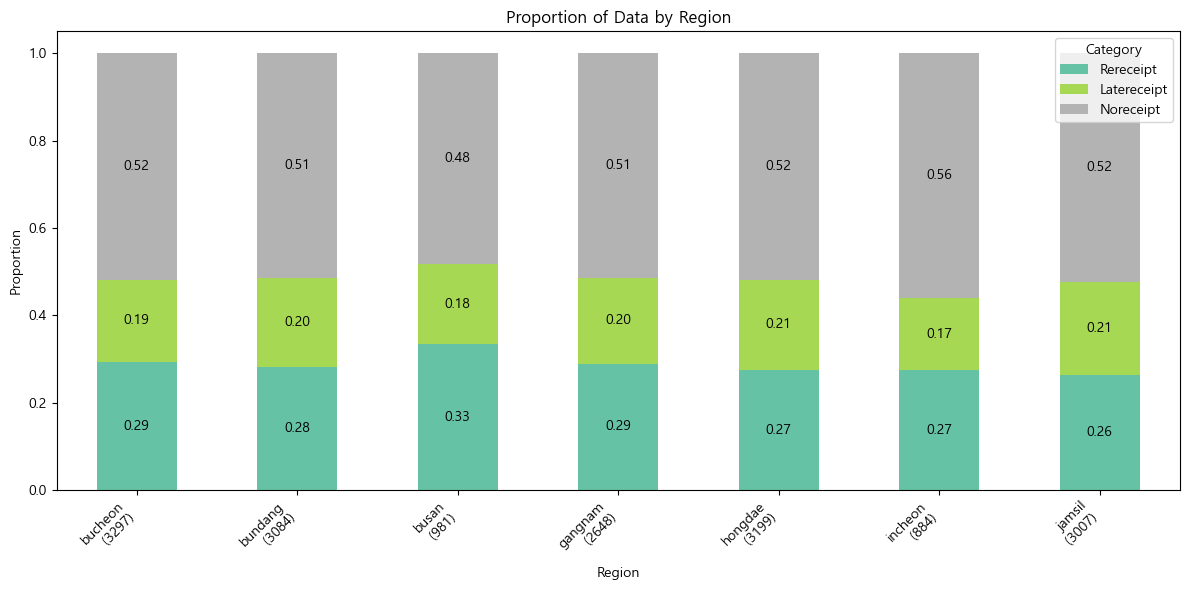

In [460]:
import pandas as pd
import matplotlib.pyplot as plt

# Region별 각 데이터군의 개수 계산
rereceipt_region_count = rereceipt_info_df['Region'].value_counts()
latereceipt_region_count = latereceipt_info_df['Region'].value_counts()
noreceipt_region_count = noreceipt_info_df['Region'].value_counts()

# 전체 데이터군의 합계 계산
total_region_count = rereceipt_region_count + latereceipt_region_count + noreceipt_region_count

# 비율 계산
rereceipt_region_ratio = rereceipt_region_count / total_region_count
latereceipt_region_ratio = latereceipt_region_count / total_region_count
noreceipt_region_ratio = noreceipt_region_count / total_region_count

# 비율을 데이터프레임으로 정리
region_ratio_df = pd.DataFrame({
    'Rereceipt': rereceipt_region_ratio,
    'Latereceipt': latereceipt_region_ratio,
    'Noreceipt': noreceipt_region_ratio
}).fillna(0)  # NaN 값을 0으로 채우기

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
ax = region_ratio_df.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

# x축의 글자를 가로로 표시 및 크기 표시
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels([f'{region}\n({total_region_count[region]})' for region in region_ratio_df.index])

# 그래프 제목 및 축 레이블 설정
plt.title('Proportion of Data by Region')
plt.xlabel('Region')
plt.ylabel('Proportion')

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='Category', loc='upper right')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()


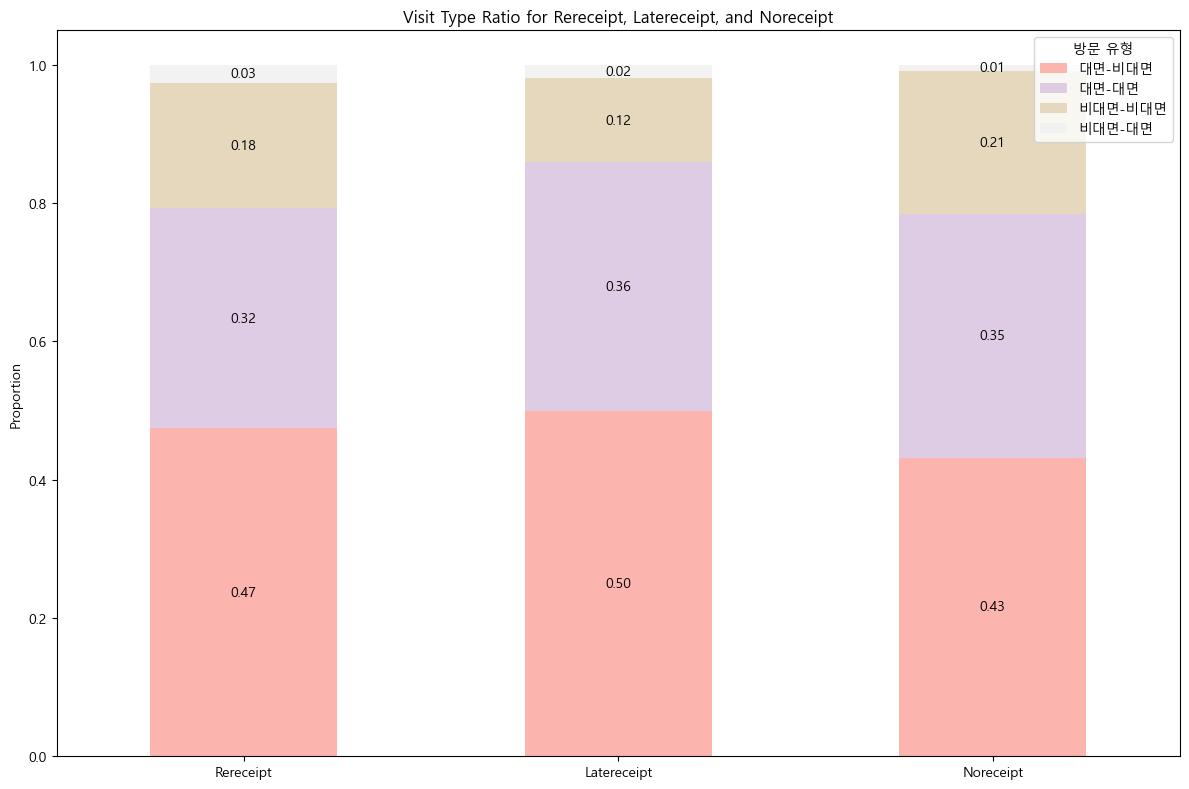

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Visit 열의 유형을 분류하는 함수 정의
def classify_visit_type(visit_list):
    if 1 not in visit_list:
        return 'Visit'
    elif 2 not in visit_list:
        return 'No Visit'
    elif visit_list[0] == 1 and 2 in visit_list:
        return 'Visit then No Visit'
    elif visit_list[0] == 2 and 1 in visit_list:
        return 'No Visit then Visit'
    else:
        return 'Other'

# 각 데이터프레임에 대해 유형 분류 및 비율 계산
def compute_visit_type_ratios(df):
    visit_type_counts = df['Visit'].apply(classify_visit_type).value_counts(normalize=True)
    return visit_type_counts

rereceipt_visit_ratio = compute_visit_type_ratios(rereceipt_df)
latereceipt_visit_ratio = compute_visit_type_ratios(latereceipt_df)
noreceipt_visit_ratio = compute_visit_type_ratios(noreceipt_df)

# 비율을 데이터프레임으로 정리
visit_ratio_df = pd.DataFrame({
    'Rereceipt': rereceipt_visit_ratio,
    'Latereceipt': latereceipt_visit_ratio,
    'Noreceipt': noreceipt_visit_ratio
}).T

# 비율이 0인 경우에도 그래프에 표시되도록 0으로 채우기
visit_ratio_df = visit_ratio_df.fillna(0)

# 막대 그래프 시각화
plt.figure(figsize=(12, 8))
ax = visit_ratio_df.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())

# 그래프 제목 및 축 레이블 설정
plt.title('Visit Type Ratio for Rereceipt, Latereceipt, and Noreceipt')
plt.ylabel('Proportion')

# x축의 글자를 가로로 표시
plt.xticks(rotation=0)

# 막대 그래프 위에 비율 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='black')

# 범례 표시
plt.legend(title='방문 유형' , labels =['대면-비대면','대면-대면','비대면-비대면','비대면-대면'] , loc='upper right')

# 레이아웃 조정
plt.tight_layout()

plt.savefig("\\Users\\howsr\\OneDrive\\바탕 화면\\누베베\\6주 감량 조사 자료\\이미지\\Visit.png")
# 그래프 표시
plt.show()


In [24]:
rereceipt_df

,Period,Loss,Weight,Visit,Next,receipt_count
25,50,4.00,85.00,"[1.0, 2.0, 2.0, 2.0, 0.0]",50,4
33,40,3.70,56.00,"[2.0, 2.0, 2.0, 2.0, 2.0]",70,3
34,63,3.80,64.00,"[1.0, 1.0, 1.0]",98,3
45,42,6.10,78.00,"[1.0, 1.0, 2.0]",117,2
48,32,1.00,56.00,"[1.0, 2.0]",99,2
...,...,...,...,...,...,...
43809,51,2.00,64.00,"[1.0, 2.0]",99,2
43857,57,5.00,75.00,"[2.0, 2.0, 2.0]",112,2
43900,7,0.20,50.00,"[1.0, 1.0]",57,2
43916,42,2.70,71.00,"[1.0, 1.0, 2.0]",89,2


In [27]:
rereceipt_info_df

NameError: name 'rereceipt_info_df' is not defined

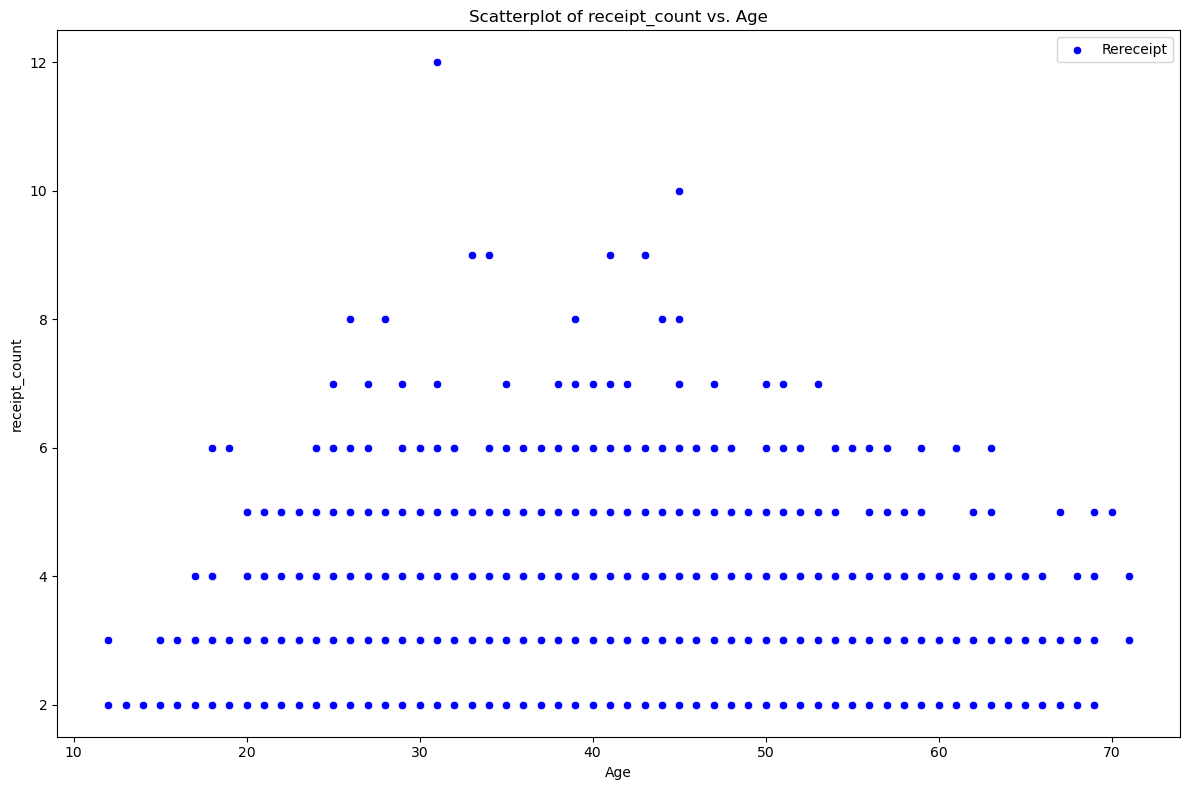

In [31]:
-